In [1]:
pip install pyspark==3.5.0 pyarrow pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, avg, sum as spark_sum, stddev, min as spark_min, max as spark_max,
    hour, dayofweek, date_format, when, abs as spark_abs,
    year, month, dayofmonth,
    countDistinct
)
from pyspark.sql.window import Window
from pyspark.sql.types import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [3]:
spark_session = (
    SparkSession.builder
    .appName("SpatioTemporal-Analysis")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.parquet.int96RebaseModeInWrite", "CORRECTED")
    .config("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED")
    .getOrCreate()
)

spark_session

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/06 12:50:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
CLEAN_DATA_PATH = "hdfs:///user/ubuntu/largest_parquet_clean_enriched/clean_enriched"
RESULTS_PATH = "hdfs:///user/ubuntu/analysis_results/spatio_temporal"

print(f"Data source: {CLEAN_DATA_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")

Data source: hdfs:///user/ubuntu/largest_parquet_clean_enriched/clean_enriched
Results will be saved to: hdfs:///user/ubuntu/analysis_results/spatio_temporal


In [5]:
from pyspark import StorageLevel

for (id, rdd) in spark_session.sparkContext._jsc.getPersistentRDDs().items():
    print(f"Cached RDD ID: {id}")

spark_session.catalog.clearCache()


In [6]:
print("Loading cleaned traffic data...")
clean_df = spark_session.read.parquet(CLEAN_DATA_PATH)

row_count = clean_df.count()
print(f"Loaded {row_count:,} rows")

print("\nSchema:")
clean_df.printSchema()

print("\nSample data:")
clean_df.show(5, truncate=False)

Loading cleaned traffic data...


Loaded 4,406,085,187 rows

Schema:
root
 |-- sensor_id: string (nullable = true)
 |-- value: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lng: double (nullable = true)
 |-- District: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Fwy: string (nullable = true)
 |-- Lanes: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Direction: string (nullable = true)
 |-- ID2: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)


Sample data:
+---------+-----+----+-------+---------+-----------+--------+---------+------+-----+--------+---------+----+-------------------+
|sensor_id|value|year|ID     |Lat      |Lng        |District|County   |Fwy   |Lanes|Type    |Direction|ID2 |timestamp          |
+---------+-----+----+-------+---------+-----------+--------+---------+------+-----+--------+---------+----+-------------------+
|1118894  |282.0|2019|1118894

In [7]:
print("Dataset Overview:")
print("="*60)

print("\nRecords by year:")
clean_df.groupBy("year").count().orderBy("year").show()

num_sensors = clean_df.select("sensor_id").distinct().count()
print(f"Total unique sensors: {num_sensors:,}")

print("\nHighways covered:")
clean_df.groupBy("Fwy").count().orderBy(col("count").desc()).show(10)

print("\nCounties covered:")
clean_df.groupBy("County").count().orderBy(col("count").desc()).show(10)

Dataset Overview:

Records by year:


+----+---------+
|year|    count|
+----+---------+
|2017|846505845|
|2018|874537005|
|2019|890370845|
|2020|899094967|
|2021|895576525|
+----+---------+



Total unique sensors: 8,600

Highways covered:


+-------+---------+
|    Fwy|    count|
+-------+---------+
|US101-N|281316327|
|US101-S|280029634|
|   I5-S|206665128|
|   I5-N|204650203|
| SR99-N|160452896|
| SR99-S|155513486|
|  I10-W|127021074|
|  I10-E|126380746|
|  I80-E|126337578|
|  I80-W|121154038|
+-------+---------+
only showing top 10 rows


Counties covered:


[Stage 17:=======================================================>(84 + 1) / 85]

+--------------+---------+
|        County|    count|
+--------------+---------+
|   Los Angeles|898846444|
|        Orange|488276647|
|     San Diego|364209030|
|San Bernardino|281266587|
|   Santa Clara|278280230|
|  Contra Costa|254183353|
|       Alameda|250900948|
|     Riverside|247206214|
|    Sacramento|161188724|
|   San Joaquin|159658921|
+--------------+---------+
only showing top 10 rows



In [18]:
import pandas as pd

print("Analyzing sampling intervals for 3 sensors...")
print("="*70)

sample_sensors = (
    clean_df
    .select("sensor_id")
    .distinct()
    .limit(3)
).toPandas()['sensor_id'].tolist()

print(f"Selected sensors: {sample_sensors}\n")

for sensor_id in sample_sensors:
    print(f"\n{'='*70}")
    print(f"SENSOR: {sensor_id}")
    print(f"{'='*70}")
    
    sensor_data = (
        clean_df
        .filter(col("sensor_id") == sensor_id)
        .select("timestamp", "value")
        .orderBy("timestamp")
        .limit(15)
    ).toPandas()
    
    if len(sensor_data) < 2:
        print("Not enough data for this sensor")
        continue
    
    sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
    
    sensor_data['time_diff'] = sensor_data['timestamp'].diff()
    sensor_data['time_diff_minutes'] = sensor_data['time_diff'].dt.total_seconds() / 60
    
    print("\nFirst 10 readings:")
    print(sensor_data[['timestamp', 'value', 'time_diff_minutes']].head(10).to_string(index=False))
    
    intervals = sensor_data['time_diff_minutes'].dropna()
    if len(intervals) > 0:
        most_common_interval = intervals.mode().values[0] if len(intervals.mode()) > 0 else intervals.median()
        print(f"\n Sampling interval: {most_common_interval:.0f} minutes")
    else:
        print("\nCould not determine interval")


Analyzing sampling intervals for 3 sensors...


Selected sensors: ['1113473', '1204436', '1205135']


SENSOR: 1113473



First 10 readings:
          timestamp  value  time_diff_minutes
2017-01-01 00:00:00   60.0                NaN
2017-01-01 00:05:00   44.0                5.0
2017-01-01 00:10:00   32.0                5.0
2017-01-01 00:15:00   64.0                5.0
2017-01-01 00:20:00   84.0                5.0
2017-01-01 00:25:00   72.0                5.0
2017-01-01 00:30:00   87.0                5.0
2017-01-01 00:35:00   78.0                5.0
2017-01-01 00:40:00   67.0                5.0
2017-01-01 00:45:00   81.0                5.0

 Sampling interval: 5 minutes

SENSOR: 1204436



First 10 readings:
          timestamp  value  time_diff_minutes
2017-01-01 00:00:00  125.0                NaN
2017-01-01 00:05:00   80.0                5.0
2017-01-01 00:10:00  108.0                5.0
2017-01-01 00:15:00  133.0                5.0
2017-01-01 00:20:00  164.0                5.0
2017-01-01 00:25:00  177.0                5.0
2017-01-01 00:30:00  151.0                5.0
2017-01-01 00:35:00  176.0                5.0
2017-01-01 00:40:00  148.0                5.0
2017-01-01 00:45:00  191.0                5.0

 Sampling interval: 5 minutes

SENSOR: 1205135


[Stage 94:=======================================================>(84 + 1) / 85]


First 10 readings:
          timestamp  value  time_diff_minutes
2017-01-01 00:00:00  113.0                NaN
2017-01-01 00:05:00   68.0                5.0
2017-01-01 00:10:00  108.0                5.0
2017-01-01 00:15:00  147.0                5.0
2017-01-01 00:20:00  199.0                5.0
2017-01-01 00:25:00  235.0                5.0
2017-01-01 00:30:00  239.0                5.0
2017-01-01 00:35:00  246.0                5.0
2017-01-01 00:40:00  254.0                5.0
2017-01-01 00:45:00  235.0                5.0

 Sampling interval: 5 minutes


In [19]:
#!hdfs dfs -rm -r /user/ubuntu/analysis_results/spatio_temporal/sensor_statistics

Deleted /user/ubuntu/analysis_results/spatio_temporal/sensor_statistics


In [23]:
print("Checking for sensor-level traffic flow statistics...")
sensor_stats_path = f"{RESULTS_PATH}/sensor_statistics"

try:
    sensor_stats = spark_session.read.parquet(sensor_stats_path).cache()
    sensor_count = sensor_stats.count()
    print(f"Loaded existing sensor statistics: {sensor_count:,} sensors")
    print(f"   (from {sensor_stats_path})")
    
except:
    print("No existing statistics found. Computing from scratch...")
    
    # Flow thresholds (vehicles per 5 minutes per lane)
    # Based on standard highway capacity: ~200 veh/5min/lane at capacity
    LOW_FLOW_PER_LANE = 30      # Light traffic
    NORMAL_FLOW_PER_LANE = 100  # Normal flow
    HIGH_FLOW_PER_LANE = 150    # Heavy traffic
    CAPACITY_PER_LANE = 180     # Near capacity (congestion threshold)
    
    sensor_stats = (
        clean_df
        .groupBy("sensor_id", "Fwy", "County", "Lat", "Lng", "Lanes", "Type", "Direction")
        .agg(
            # Basic flow statistics
            avg("value").alias("avg_flow"),
            stddev("value").alias("flow_variance"),
            spark_min("value").alias("min_flow"),
            spark_max("value").alias("max_flow"),
            count("*").alias("num_readings"),
            
            # Per-lane flow (more meaningful metric)
            (avg("value") / col("Lanes")).alias("avg_flow_per_lane"),
            
            # Traffic intensity metrics (based on per-lane flow)
            # LOW FLOW = empty/light traffic (good!)
            (spark_sum(when(col("value") / col("Lanes") < LOW_FLOW_PER_LANE, 1).otherwise(0)) / count("*") * 100)
                .alias("low_flow_pct"),
            
            # NORMAL FLOW = moderate traffic
            (spark_sum(when(
                (col("value") / col("Lanes") >= LOW_FLOW_PER_LANE) & 
                (col("value") / col("Lanes") < HIGH_FLOW_PER_LANE), 1
            ).otherwise(0)) / count("*") * 100)
                .alias("normal_flow_pct"),
            
            # HIGH FLOW = heavy traffic (approaching congestion)
            (spark_sum(when(
                (col("value") / col("Lanes") >= HIGH_FLOW_PER_LANE) & 
                (col("value") / col("Lanes") < CAPACITY_PER_LANE), 1
            ).otherwise(0)) / count("*") * 100)
                .alias("heavy_flow_pct"),
            
            # CONGESTED = at/over capacity (BAD!)
            (spark_sum(when(col("value") / col("Lanes") >= CAPACITY_PER_LANE, 1).otherwise(0)) / count("*") * 100)
                .alias("congestion_pct"),
            
            (spark_sum(when(col("value") / col("Lanes") >= CAPACITY_PER_LANE * 1.1, 1).otherwise(0)) / count("*") * 100)
                .alias("severe_congestion_pct")
        )
        .filter(col("num_readings") > 1000)
        .cache()
    )
    
    sensor_count = sensor_stats.count()
    print(f"Computed statistics for {sensor_count:,} sensors")
    
    print(f"\nSaving to {sensor_stats_path}...")
    sensor_stats.write.mode("overwrite").parquet(sensor_stats_path)
    print("Sensor statistics saved")

print("\n" + "="*100)
print("Sample sensor statistics:")
print("="*100)
sensor_stats.select(
    "sensor_id", "Fwy", "County", "Lanes", 
    "avg_flow", "avg_flow_per_lane", "flow_variance",
    "low_flow_pct", "normal_flow_pct", "heavy_flow_pct", "congestion_pct"
).show(5, truncate=False)

print("\nMetric Definitions:")
print("="*100)
print("avg_flow:          Average vehicles per 5 minutes (all lanes)")
print("avg_flow_per_lane: Average vehicles per 5 minutes per lane")
print("flow_variance:     Standard deviation of flow")
print("low_flow_pct:      % of time with light traffic (<30 veh/5min/lane)")
print("normal_flow_pct:   % of time with normal traffic (30-150 veh/5min/lane)")
print("heavy_flow_pct:    % of time with heavy traffic (150-180 veh/5min/lane)")
print("congestion_pct:    % of time at/over capacity (≥180 veh/5min/lane)")
print("\nCapacity reference: ~180-200 vehicles/5min/lane = 2,160-2,400 veh/hr/lane")

Checking for sensor-level traffic flow statistics...
No existing statistics found. Computing from scratch...


Computed statistics for 8,600 sensors

Saving to hdfs:///user/ubuntu/analysis_results/spatio_temporal/sensor_statistics...
Sensor statistics saved

Sample sensor statistics:
+---------+-------+-----------+-----+------------------+-----------------+------------------+------------------+-----------------+--------------------+--------------------+
|sensor_id|Fwy    |County     |Lanes|avg_flow          |avg_flow_per_lane|flow_variance     |low_flow_pct      |normal_flow_pct  |heavy_flow_pct      |congestion_pct      |
+---------+-------+-----------+-----+------------------+-----------------+------------------+------------------+-----------------+--------------------+--------------------+
|718012   |I710-S |Los Angeles|5    |366.7440819229994 |73.34881638459987|179.83157976037393|17.023101707616757|82.96282348286867|0.014074809514571233|0.0                 |
|759271   |US101-N|Los Angeles|4    |266.17911069437656|66.54477767359414|161.33878625885006|27.364244809150577|72.53533315201577|0.09

In [24]:
print("Categorizing traffic patterns based on flow intensity and variability...")
print("\nCategory Definitions:")
print("="*70)
print("1. LIGHT & STABLE")
print("   - Low average flow (<80 veh/5min/lane)")
print("   - Low variance - consistent pattern")
print("   - Typical: Rural highways, off-peak hours")
print("\n2. LIGHT & VARIABLE")
print("   - Low average flow (<80 veh/5min/lane)")
print("   - High variance - inconsistent pattern")
print("   - Typical: Sporadic usage, weekend routes")
print("\n3. MODERATE & STABLE")
print("   - Medium flow (80-140 veh/5min/lane)")
print("   - Low variance - steady flow")
print("   - Typical: Well-functioning urban highways")
print("\n4. MODERATE & VARIABLE")
print("   - Medium flow (80-140 veh/5min/lane)")
print("   - High variance - peak/off-peak differences")
print("   - Typical: Commuter routes (MOST COMMON!)")
print("\n5. HEAVY & STABLE")
print("   - High flow (140-180 veh/5min/lane)")
print("   - Low variance - consistently heavy")
print("   - Typical: Major corridors, always busy")
print("\n6. CONGESTED")
print("   - Very high flow (≥180 veh/5min/lane)")
print("   - Any variance - at/over capacity")
print("   - Typical: Bottlenecks, problem areas")
print("="*70)

traffic_categories = (
    sensor_stats
    .withColumn(
        "traffic_pattern",
        when(
            # CONGESTED: At or over capacity (regardless of variance)
            col("avg_flow_per_lane") >= 180,
            "Congested"
        ).when(
            # HEAVY & STABLE: High flow, low variance
            (col("avg_flow_per_lane") >= 140) & 
            (col("avg_flow_per_lane") < 180) & 
            (col("flow_variance") / col("avg_flow") < 0.5),  # Low coefficient of variation
            "Heavy & Stable"
        ).when(
            # HEAVY & VARIABLE: High flow, high variance
            (col("avg_flow_per_lane") >= 140) & 
            (col("avg_flow_per_lane") < 180) & 
            (col("flow_variance") / col("avg_flow") >= 0.5),
            "Heavy & Variable"
        ).when(
            # MODERATE & STABLE: Medium flow, low variance
            (col("avg_flow_per_lane") >= 80) & 
            (col("avg_flow_per_lane") < 140) & 
            (col("flow_variance") / col("avg_flow") < 0.5),
            "Moderate & Stable"
        ).when(
            # MODERATE & VARIABLE: Medium flow, high variance (MOST COMMON!)
            (col("avg_flow_per_lane") >= 80) & 
            (col("avg_flow_per_lane") < 140) & 
            (col("flow_variance") / col("avg_flow") >= 0.5),
            "Moderate & Variable"
        ).when(
            # LIGHT & STABLE: Low flow, low variance
            (col("avg_flow_per_lane") < 80) & 
            (col("flow_variance") / col("avg_flow") < 0.5),
            "Light & Stable"
        ).when(
            # LIGHT & VARIABLE: Low flow, high variance
            (col("avg_flow_per_lane") < 80) & 
            (col("flow_variance") / col("avg_flow") >= 0.5),
            "Light & Variable"
        ).otherwise("Other")
    )
    .cache()
)

total = traffic_categories.count()
print(f"\n Categorized {total:,} sensors")

print("\nTraffic Pattern Distribution:")
print("="*100)
pattern_distribution = (
    traffic_categories
    .groupBy("traffic_pattern")
    .agg(
        count("*").alias("count"),
        avg("avg_flow_per_lane").alias("mean_flow_per_lane"),
        avg("flow_variance").alias("mean_variance"),
        avg("congestion_pct").alias("mean_congestion_pct")
    )
    .orderBy(col("count").desc())
)
pattern_distribution.show(truncate=False)

pattern_df = pattern_distribution.toPandas()
pattern_df['percentage'] = pattern_df['count'] / pattern_df['count'].sum() * 100

print("\nPercentage Breakdown:")
for _, row in pattern_df.iterrows():
    print(f"{row['traffic_pattern']:25s}: {row['count']:6,d} sensors ({row['percentage']:5.1f}%) - "
          f"avg flow: {row['mean_flow_per_lane']:5.1f} veh/5min/lane")

print("\nSaving categorized data...")
traffic_categories.write.mode("overwrite").parquet(f"{RESULTS_PATH}/traffic_categories")
print("Saved")

print("\nSample categorized sensors:")
print("="*100)
traffic_categories.select(
    "sensor_id", "Fwy", "County", "avg_flow_per_lane", "flow_variance",
    "congestion_pct", "traffic_pattern"
).show(10, truncate=False)

Categorizing traffic patterns based on flow intensity and variability...

Category Definitions:
1. LIGHT & STABLE
   - Low average flow (<80 veh/5min/lane)
   - Low variance - consistent pattern
   - Typical: Rural highways, off-peak hours

2. LIGHT & VARIABLE
   - Low average flow (<80 veh/5min/lane)
   - High variance - inconsistent pattern
   - Typical: Sporadic usage, weekend routes

3. MODERATE & STABLE
   - Medium flow (80-140 veh/5min/lane)
   - Low variance - steady flow
   - Typical: Well-functioning urban highways

4. MODERATE & VARIABLE
   - Medium flow (80-140 veh/5min/lane)
   - High variance - peak/off-peak differences
   - Typical: Commuter routes (MOST COMMON!)

5. HEAVY & STABLE
   - High flow (140-180 veh/5min/lane)
   - Low variance - consistently heavy
   - Typical: Major corridors, always busy

6. CONGESTED
   - Very high flow (≥180 veh/5min/lane)
   - Any variance - at/over capacity
   - Typical: Bottlenecks, problem areas

 Categorized 8,600 sensors

Traffic Patt

Analyzing category distribution...

Traffic Pattern Distribution:
+-------------------+-----+------------------+------------------+-------------------+------------------+-------------------+
|traffic_pattern    |count|mean_flow_per_lane|mean_variance     |mean_congestion    |mean_low_flow     |mean_heavy_flow    |
+-------------------+-----+------------------+------------------+-------------------+------------------+-------------------+
|Light & Variable   |5949 |54.68210105464655 |117.96265599520656|0.06204862937573126|33.582553994362854|0.502414692117996  |
|Light & Stable     |1167 |65.92429961069857 |124.52125863873661|0.01618564026512484|19.75279655542035 |0.16445637445832426|
|Moderate & Stable  |977  |90.12676416818819 |164.1635498170586 |0.47706101233173925|12.54423254506327 |4.003309340113122  |
|Moderate & Variable|503  |87.84710918257814 |180.64934298063608|1.7782995471832495 |18.801703695250268|6.37755629767487   |
|Heavy & Variable   |2    |156.21411214417483|153.447016775

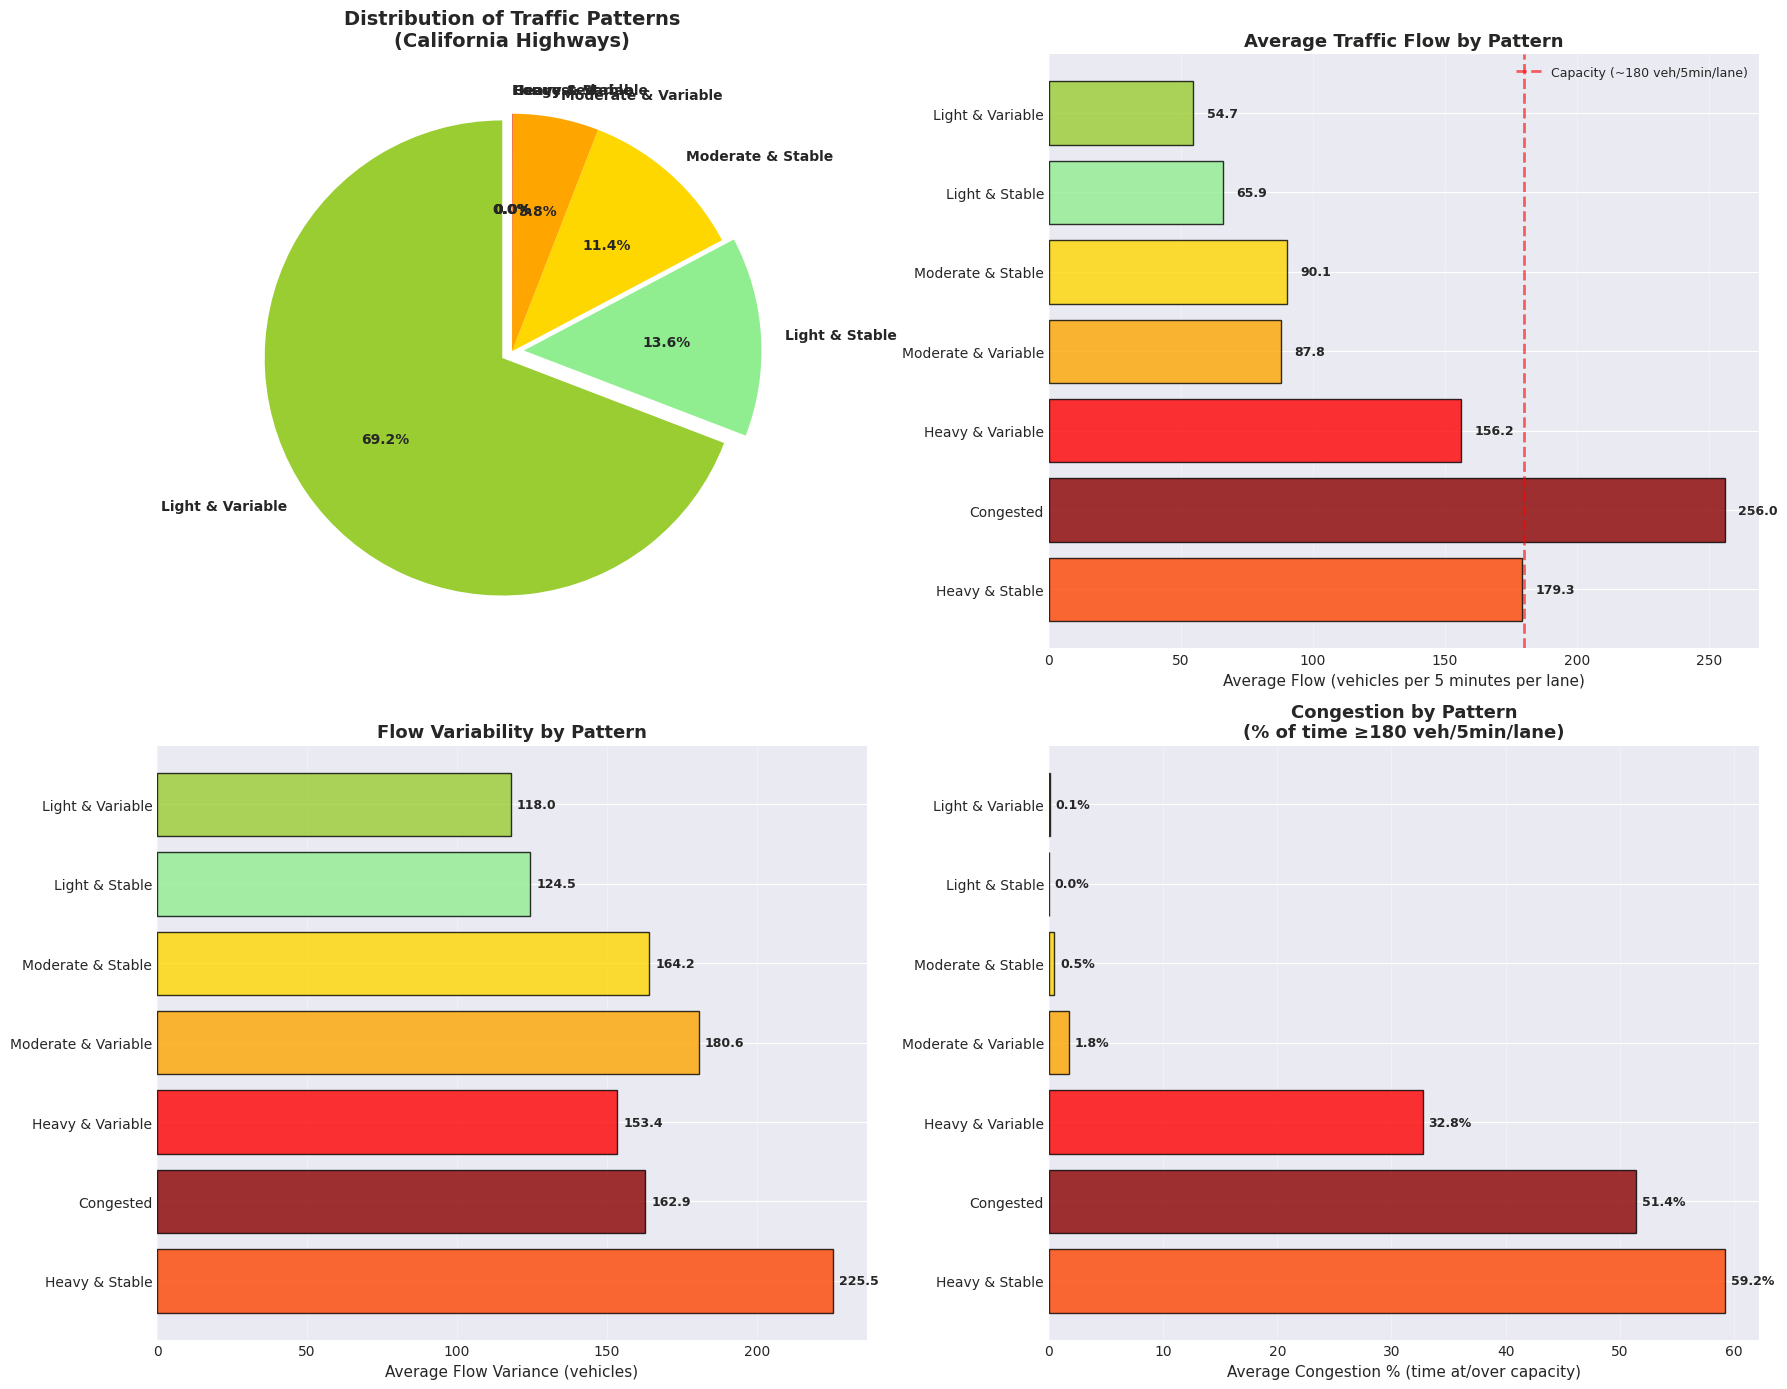


✓ Traffic pattern distribution analysis complete

KEY INSIGHTS:

1. DOMINANT PATTERN: Light & Variable
   - 69.2% of all sensors
   - Average flow: 54.7 vehicles per 5 minutes per lane
   - Average congestion: 0.1% of time

2. MOST CONGESTED PATTERN: Heavy & Stable
   - 0.0% of sensors
   - Average flow: 179.3 vehicles per 5 minutes per lane
   - Congestion: 59.2% of time

3. PROBLEM AREAS (Heavy/Congested patterns):
   - 4 sensors (0.0%)
   - These segments need attention:
     • Heavy & Variable    : 2 sensors
     • Congested           : 1 sensors
     • Heavy & Stable      : 1 sensors

4. CAPACITY UTILIZATION:
   - Average flow across all sensors: 127.2 veh/5min/lane
   - Average capacity utilization: 70.6%
   → System is well-utilized (healthy)



In [25]:
print("Analyzing category distribution...")

pattern_distribution = (
    traffic_categories
    .groupBy("traffic_pattern")
    .agg(
        count("*").alias("count"),
        avg("avg_flow_per_lane").alias("mean_flow_per_lane"),
        avg("flow_variance").alias("mean_variance"),
        avg("congestion_pct").alias("mean_congestion"),
        avg("low_flow_pct").alias("mean_low_flow"),
        avg("heavy_flow_pct").alias("mean_heavy_flow")
    )
    .orderBy(col("count").desc())
)

print("\nTraffic Pattern Distribution:")
print("="*100)
pattern_distribution.show(truncate=False)

pattern_df = pattern_distribution.toPandas()
pattern_df['percentage'] = pattern_df['count'] / pattern_df['count'].sum() * 100

print("\nPercentage Breakdown:")
for _, row in pattern_df.iterrows():
    print(f"{row['traffic_pattern']:25s}: {row['count']:6,d} sensors ({row['percentage']:5.1f}%) - "
          f"avg flow: {row['mean_flow_per_lane']:5.1f} veh/5min/lane")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

colors_map = {
    'Light & Stable': 'lightgreen',
    'Light & Variable': 'yellowgreen',
    'Moderate & Stable': 'gold',
    'Moderate & Variable': 'orange',
    'Heavy & Stable': 'orangered',
    'Heavy & Variable': 'red',
    'Congested': 'darkred',
    'Other': 'gray'
}
colors = [colors_map.get(p, 'gray') for p in pattern_df['traffic_pattern']]

# Plot 1: Pie chart
ax1 = axes[0, 0]
explode = tuple([0.05 if i < 2 else 0 for i in range(len(pattern_df))])

ax1.pie(
    pattern_df['count'],
    labels=pattern_df['traffic_pattern'],
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=90,
    textprops={'fontsize': 10, 'weight': 'bold'}
)
ax1.set_title('Distribution of Traffic Patterns\n(California Highways)', 
              fontsize=14, fontweight='bold')

# Plot 2: Average flow per lane by pattern
ax2 = axes[0, 1]
bars = ax2.barh(
    range(len(pattern_df)),
    pattern_df['mean_flow_per_lane'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)
ax2.set_yticks(range(len(pattern_df)))
ax2.set_yticklabels(pattern_df['traffic_pattern'], fontsize=10)
ax2.set_xlabel('Average Flow (vehicles per 5 minutes per lane)', fontsize=11)
ax2.set_title('Average Traffic Flow by Pattern', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add capacity reference line
ax2.axvline(x=180, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label='Capacity (~180 veh/5min/lane)')
ax2.legend(fontsize=9)

for i, v in enumerate(pattern_df['mean_flow_per_lane']):
    ax2.text(v + 5, i, f'{v:.1f}', va='center', fontsize=9, fontweight='bold')

# Plot 3: Flow variance by pattern
ax3 = axes[1, 0]
ax3.barh(
    range(len(pattern_df)),
    pattern_df['mean_variance'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)
ax3.set_yticks(range(len(pattern_df)))
ax3.set_yticklabels(pattern_df['traffic_pattern'], fontsize=10)
ax3.set_xlabel('Average Flow Variance (vehicles)', fontsize=11)
ax3.set_title('Flow Variability by Pattern', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

for i, v in enumerate(pattern_df['mean_variance']):
    ax3.text(v + 2, i, f'{v:.1f}', va='center', fontsize=9, fontweight='bold')

# Plot 4: Congestion % by pattern
ax4 = axes[1, 1]
ax4.barh(
    range(len(pattern_df)),
    pattern_df['mean_congestion'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)
ax4.set_yticks(range(len(pattern_df)))
ax4.set_yticklabels(pattern_df['traffic_pattern'], fontsize=10)
ax4.set_xlabel('Average Congestion % (time at/over capacity)', fontsize=11)
ax4.set_title('Congestion by Pattern\n(% of time ≥180 veh/5min/lane)', 
             fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

for i, v in enumerate(pattern_df['mean_congestion']):
    ax4.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('traffic_pattern_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Traffic pattern distribution analysis complete")

# Additional insights
print("\n" + "="*100)
print("KEY INSIGHTS:")
print("="*100)

# Find dominant pattern
dominant = pattern_df.iloc[0]
print(f"\n1. DOMINANT PATTERN: {dominant['traffic_pattern']}")
print(f"   - {dominant['percentage']:.1f}% of all sensors")
print(f"   - Average flow: {dominant['mean_flow_per_lane']:.1f} vehicles per 5 minutes per lane")
print(f"   - Average congestion: {dominant['mean_congestion']:.1f}% of time")

# Find most congested pattern
most_congested = pattern_df.loc[pattern_df['mean_congestion'].idxmax()]
print(f"\n2. MOST CONGESTED PATTERN: {most_congested['traffic_pattern']}")
print(f"   - {most_congested['percentage']:.1f}% of sensors")
print(f"   - Average flow: {most_congested['mean_flow_per_lane']:.1f} vehicles per 5 minutes per lane")
print(f"   - Congestion: {most_congested['mean_congestion']:.1f}% of time")

# Count problem areas
problem_patterns = pattern_df[pattern_df['traffic_pattern'].isin(['Heavy & Variable', 'Heavy & Stable', 'Congested'])]
problem_total = problem_patterns['count'].sum()
problem_pct = problem_total / pattern_df['count'].sum() * 100

print(f"\n3. PROBLEM AREAS (Heavy/Congested patterns):")
print(f"   - {problem_total:,} sensors ({problem_pct:.1f}%)")
print(f"   - These segments need attention:")
for _, row in problem_patterns.iterrows():
    print(f"     • {row['traffic_pattern']:20s}: {int(row['count']):,} sensors")

# Capacity analysis
print(f"\n4. CAPACITY UTILIZATION:")
capacity_usage = pattern_df['mean_flow_per_lane'].mean()
capacity_pct = (capacity_usage / 180) * 100  # 180 veh/5min/lane = capacity
print(f"   - Average flow across all sensors: {capacity_usage:.1f} veh/5min/lane")
print(f"   - Average capacity utilization: {capacity_pct:.1f}%")
if capacity_pct < 60:
    print(f"   → System is under-utilized (plenty of capacity)")
elif capacity_pct < 80:
    print(f"   → System is well-utilized (healthy)")
elif capacity_pct < 90:
    print(f"   → System is near capacity (monitor closely)")
else:
    print(f"   → System is over capacity (critical)")

print("\n" + "="*100)

Comparing problem segments vs. good segments...

Segment Definitions:
  Problem segments: Heavy & Stable, Heavy & Variable, Congested
  Good segments: Light/Moderate patterns with <5% congestion

Counts:
  Problem segments: 4
  Good segments: 8,545
  Ratio: 2136.2:1 (good:problem)

Comparison Statistics:
        Category  Count  Avg Flow (veh/5min/lane)  Avg Variance  Congestion %  Heavy Flow %  Low Flow %
Problem Segments      4                186.935839    173.826037     44.030494      9.650220    5.102453
   Good Segments   8545                 61.939198    127.675089      0.114054      1.115382   28.496939


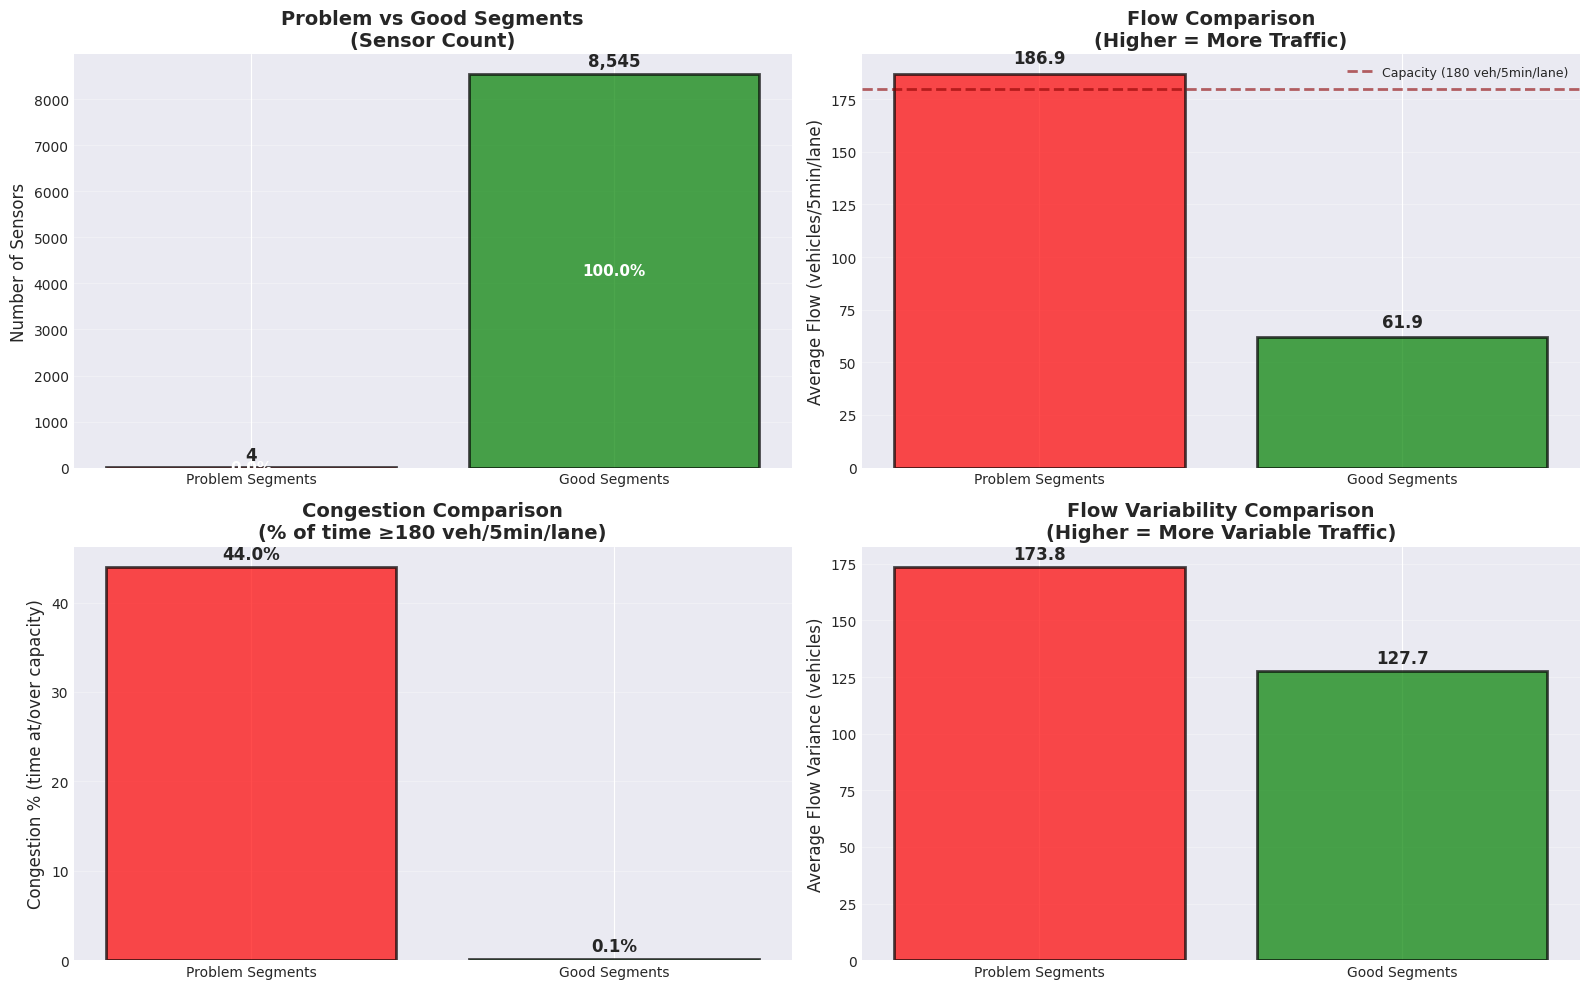


 Comparison complete

KEY INSIGHTS FROM COMPARISON:

1. FLOW DIFFERENCE:
   Problem segments have 125.0 more veh/5min/lane than good segments
   (186.9 vs 61.9)
   Problem segments operating near/over capacity!

2. CONGESTION DIFFERENCE:
   Problem segments congested 43.9% more of the time
   (44.0% vs 0.1%)
   Problem segments are 386.0× more congested!

3. VARIABILITY:
   Problem segments have 46.2 more flow variance
   (173.8 vs 127.7)

4. SYSTEM HEALTH:
   Good segments: 100.0% of analyzed sensors
   Problem segments: 0.0% of analyzed sensors
   System is HEALTHY (few problem areas)

5. RECOMMENDATIONS:
   Focus on targeted improvements at 4 problem locations
   Problem areas are isolated, not systemic



In [26]:
print("Comparing problem segments vs. good segments...")
print("="*100)

# Define PROBLEM segments: Heavy and Congested patterns
problem_segments = traffic_categories.filter(
    col("traffic_pattern").isin(["Heavy & Stable", "Heavy & Variable", "Congested"])
)
problem_count = problem_segments.count()

# Define GOOD segments: Light and Moderate with low congestion
good_segments = traffic_categories.filter(
    (col("traffic_pattern").isin(["Light & Stable", "Moderate & Stable"])) |
    ((col("traffic_pattern").isin(["Light & Variable", "Moderate & Variable"])) & 
     (col("congestion_pct") < 5))
)
good_count = good_segments.count()

print(f"\nSegment Definitions:")
print(f"  Problem segments: Heavy & Stable, Heavy & Variable, Congested")
print(f"  Good segments: Light/Moderate patterns with <5% congestion")

print(f"\nCounts:")
print(f"  Problem segments: {problem_count:,}")
print(f"  Good segments: {good_count:,}")
print(f"  Ratio: {(good_count/problem_count):.1f}:1 (good:problem)")


problem_stats = problem_segments.select(
    avg("avg_flow_per_lane").alias("avg_flow_per_lane"),
    avg("flow_variance").alias("avg_variance"),
    avg("congestion_pct").alias("avg_congestion"),
    avg("low_flow_pct").alias("avg_low_flow"),
    avg("heavy_flow_pct").alias("avg_heavy_flow")
).collect()[0]


good_stats = good_segments.select(
    avg("avg_flow_per_lane").alias("avg_flow_per_lane"),
    avg("flow_variance").alias("avg_variance"),
    avg("congestion_pct").alias("avg_congestion"),
    avg("low_flow_pct").alias("avg_low_flow"),
    avg("heavy_flow_pct").alias("avg_heavy_flow")
).collect()[0]

comparison_df = pd.DataFrame({
    'Category': ['Problem Segments', 'Good Segments'],
    'Count': [problem_count, good_count],
    'Avg Flow (veh/5min/lane)': [problem_stats['avg_flow_per_lane'], good_stats['avg_flow_per_lane']],
    'Avg Variance': [problem_stats['avg_variance'], good_stats['avg_variance']],
    'Congestion %': [problem_stats['avg_congestion'], good_stats['avg_congestion']],
    'Heavy Flow %': [problem_stats['avg_heavy_flow'], good_stats['avg_heavy_flow']],
    'Low Flow %': [problem_stats['avg_low_flow'], good_stats['avg_low_flow']]
})

print("\nComparison Statistics:")
print("="*100)
print(comparison_df.to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Count comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(comparison_df['Category'], comparison_df['Count'],
                color=['red', 'green'], edgecolor='black', alpha=0.7, linewidth=2)
ax1.set_ylabel('Number of Sensors', fontsize=12)
ax1.set_title('Problem vs Good Segments\n(Sensor Count)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison_df['Count']):
    ax1.text(i, v + max(comparison_df['Count'])*0.02, f'{v:,}',
            ha='center', fontsize=12, fontweight='bold')
    
# Add percentage labels
for i, v in enumerate(comparison_df['Count']):
    pct = v / comparison_df['Count'].sum() * 100
    ax1.text(i, v/2, f'{pct:.1f}%', ha='center', va='center',
            fontsize=11, fontweight='bold', color='white')

# Plot 2: Average flow per lane
ax2 = axes[0, 1]
bars2 = ax2.bar(comparison_df['Category'], comparison_df['Avg Flow (veh/5min/lane)'],
                color=['red', 'green'], edgecolor='black', alpha=0.7, linewidth=2)
ax2.set_ylabel('Average Flow (vehicles/5min/lane)', fontsize=12)
ax2.set_title('Flow Comparison\n(Higher = More Traffic)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

ax2.axhline(y=180, color='darkred', linestyle='--', linewidth=2, 
           alpha=0.6, label='Capacity (180 veh/5min/lane)')
ax2.legend(fontsize=9)

for i, v in enumerate(comparison_df['Avg Flow (veh/5min/lane)']):
    ax2.text(i, v + 5, f'{v:.1f}', ha='center', fontsize=12, fontweight='bold')

ax3 = axes[1, 0]
bars3 = ax3.bar(comparison_df['Category'], comparison_df['Congestion %'],
                color=['red', 'green'], edgecolor='black', alpha=0.7, linewidth=2)
ax3.set_ylabel('Congestion % (time at/over capacity)', fontsize=12)
ax3.set_title('Congestion Comparison\n(% of time ≥180 veh/5min/lane)', 
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison_df['Congestion %']):
    ax3.text(i, v + max(comparison_df['Congestion %'])*0.02, f'{v:.1f}%',
            ha='center', fontsize=12, fontweight='bold')

ax4 = axes[1, 1]
bars4 = ax4.bar(comparison_df['Category'], comparison_df['Avg Variance'],
                color=['red', 'green'], edgecolor='black', alpha=0.7, linewidth=2)
ax4.set_ylabel('Average Flow Variance (vehicles)', fontsize=12)
ax4.set_title('Flow Variability Comparison\n(Higher = More Variable Traffic)', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison_df['Avg Variance']):
    ax4.text(i, v + max(comparison_df['Avg Variance'])*0.02, f'{v:.1f}',
            ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('problem_vs_good_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Comparison complete")

# Additional insights
print("\n" + "="*100)
print("KEY INSIGHTS FROM COMPARISON:")
print("="*100)

flow_diff = problem_stats['avg_flow_per_lane'] - good_stats['avg_flow_per_lane']
congestion_diff = problem_stats['avg_congestion'] - good_stats['avg_congestion']
variance_diff = problem_stats['avg_variance'] - good_stats['avg_variance']

print(f"\n1. FLOW DIFFERENCE:")
print(f"   Problem segments have {flow_diff:.1f} more veh/5min/lane than good segments")
print(f"   ({problem_stats['avg_flow_per_lane']:.1f} vs {good_stats['avg_flow_per_lane']:.1f})")
if problem_stats['avg_flow_per_lane'] > 150:
    print(f"   Problem segments operating near/over capacity!")

print(f"\n2. CONGESTION DIFFERENCE:")
print(f"   Problem segments congested {congestion_diff:.1f}% more of the time")
print(f"   ({problem_stats['avg_congestion']:.1f}% vs {good_stats['avg_congestion']:.1f}%)")
congestion_ratio = problem_stats['avg_congestion'] / good_stats['avg_congestion'] if good_stats['avg_congestion'] > 0 else float('inf')
print(f"   Problem segments are {congestion_ratio:.1f}× more congested!")

print(f"\n3. VARIABILITY:")
print(f"   Problem segments have {variance_diff:.1f} more flow variance")
print(f"   ({problem_stats['avg_variance']:.1f} vs {good_stats['avg_variance']:.1f})")
if variance_diff > 50:
    print(f"   Problem segments have highly unpredictable traffic!")

print(f"\n4. SYSTEM HEALTH:")
good_pct = good_count / (problem_count + good_count) * 100
problem_pct = problem_count / (problem_count + good_count) * 100
print(f"   Good segments: {good_pct:.1f}% of analyzed sensors")
print(f"   Problem segments: {problem_pct:.1f}% of analyzed sensors")

if problem_pct < 5:
    print(f"   System is HEALTHY (few problem areas)")
elif problem_pct < 15:
    print(f"   System is ACCEPTABLE (some problem areas)")
elif problem_pct < 30:
    print(f"   System has ISSUES (many problem areas)")
else:
    print(f"   System is STRESSED (widespread problems)")

print("\n5. RECOMMENDATIONS:")
if problem_count < 100:
    print(f"   Focus on targeted improvements at {problem_count} problem locations")
    print(f"   Problem areas are isolated, not systemic")
elif problem_count < 500:
    print(f"   Need corridor-level improvements")
    print(f"   Consider traffic management strategies")
else:
    print(f"   Need system-wide capacity expansion")
    print(f"   Consider alternative transportation modes")

print("\n" + "="*100)

Analyzing highways with highest traffic flow and congestion...


26/01/06 14:57:15 WARN CacheManager: Asked to cache already cached data.


Highway congestion analysis saved

TOP 20 MOST CONGESTED HIGHWAYS:
(Ranked by % of time at/over capacity - ≥180 veh/5min/lane)
+-------+-----------+------------------+------------------+-------------------+------------------------+---------------+-----------------+
|Fwy    |num_sensors|mean_flow_per_lane|mean_variance     |mean_congestion    |capacity_utilization_pct|problem_sensors|pct_problem      |
+-------+-----------+------------------+------------------+-------------------+------------------------+---------------+-----------------+
|SR142-E|14         |107.08837457212722|68.52412632647376 |13.692548079033768 |59.493541428959574      |0              |0.0              |
|SR142-W|7          |94.11627990116062 |68.80151906371171 |11.458981315858036 |52.286822167311456      |0              |0.0              |
|SR25-N |6          |68.34521598286587 |57.747334724256156|9.659524741944528  |37.96956443492548       |0              |0.0              |
|I105-E |40         |95.60722860321468 

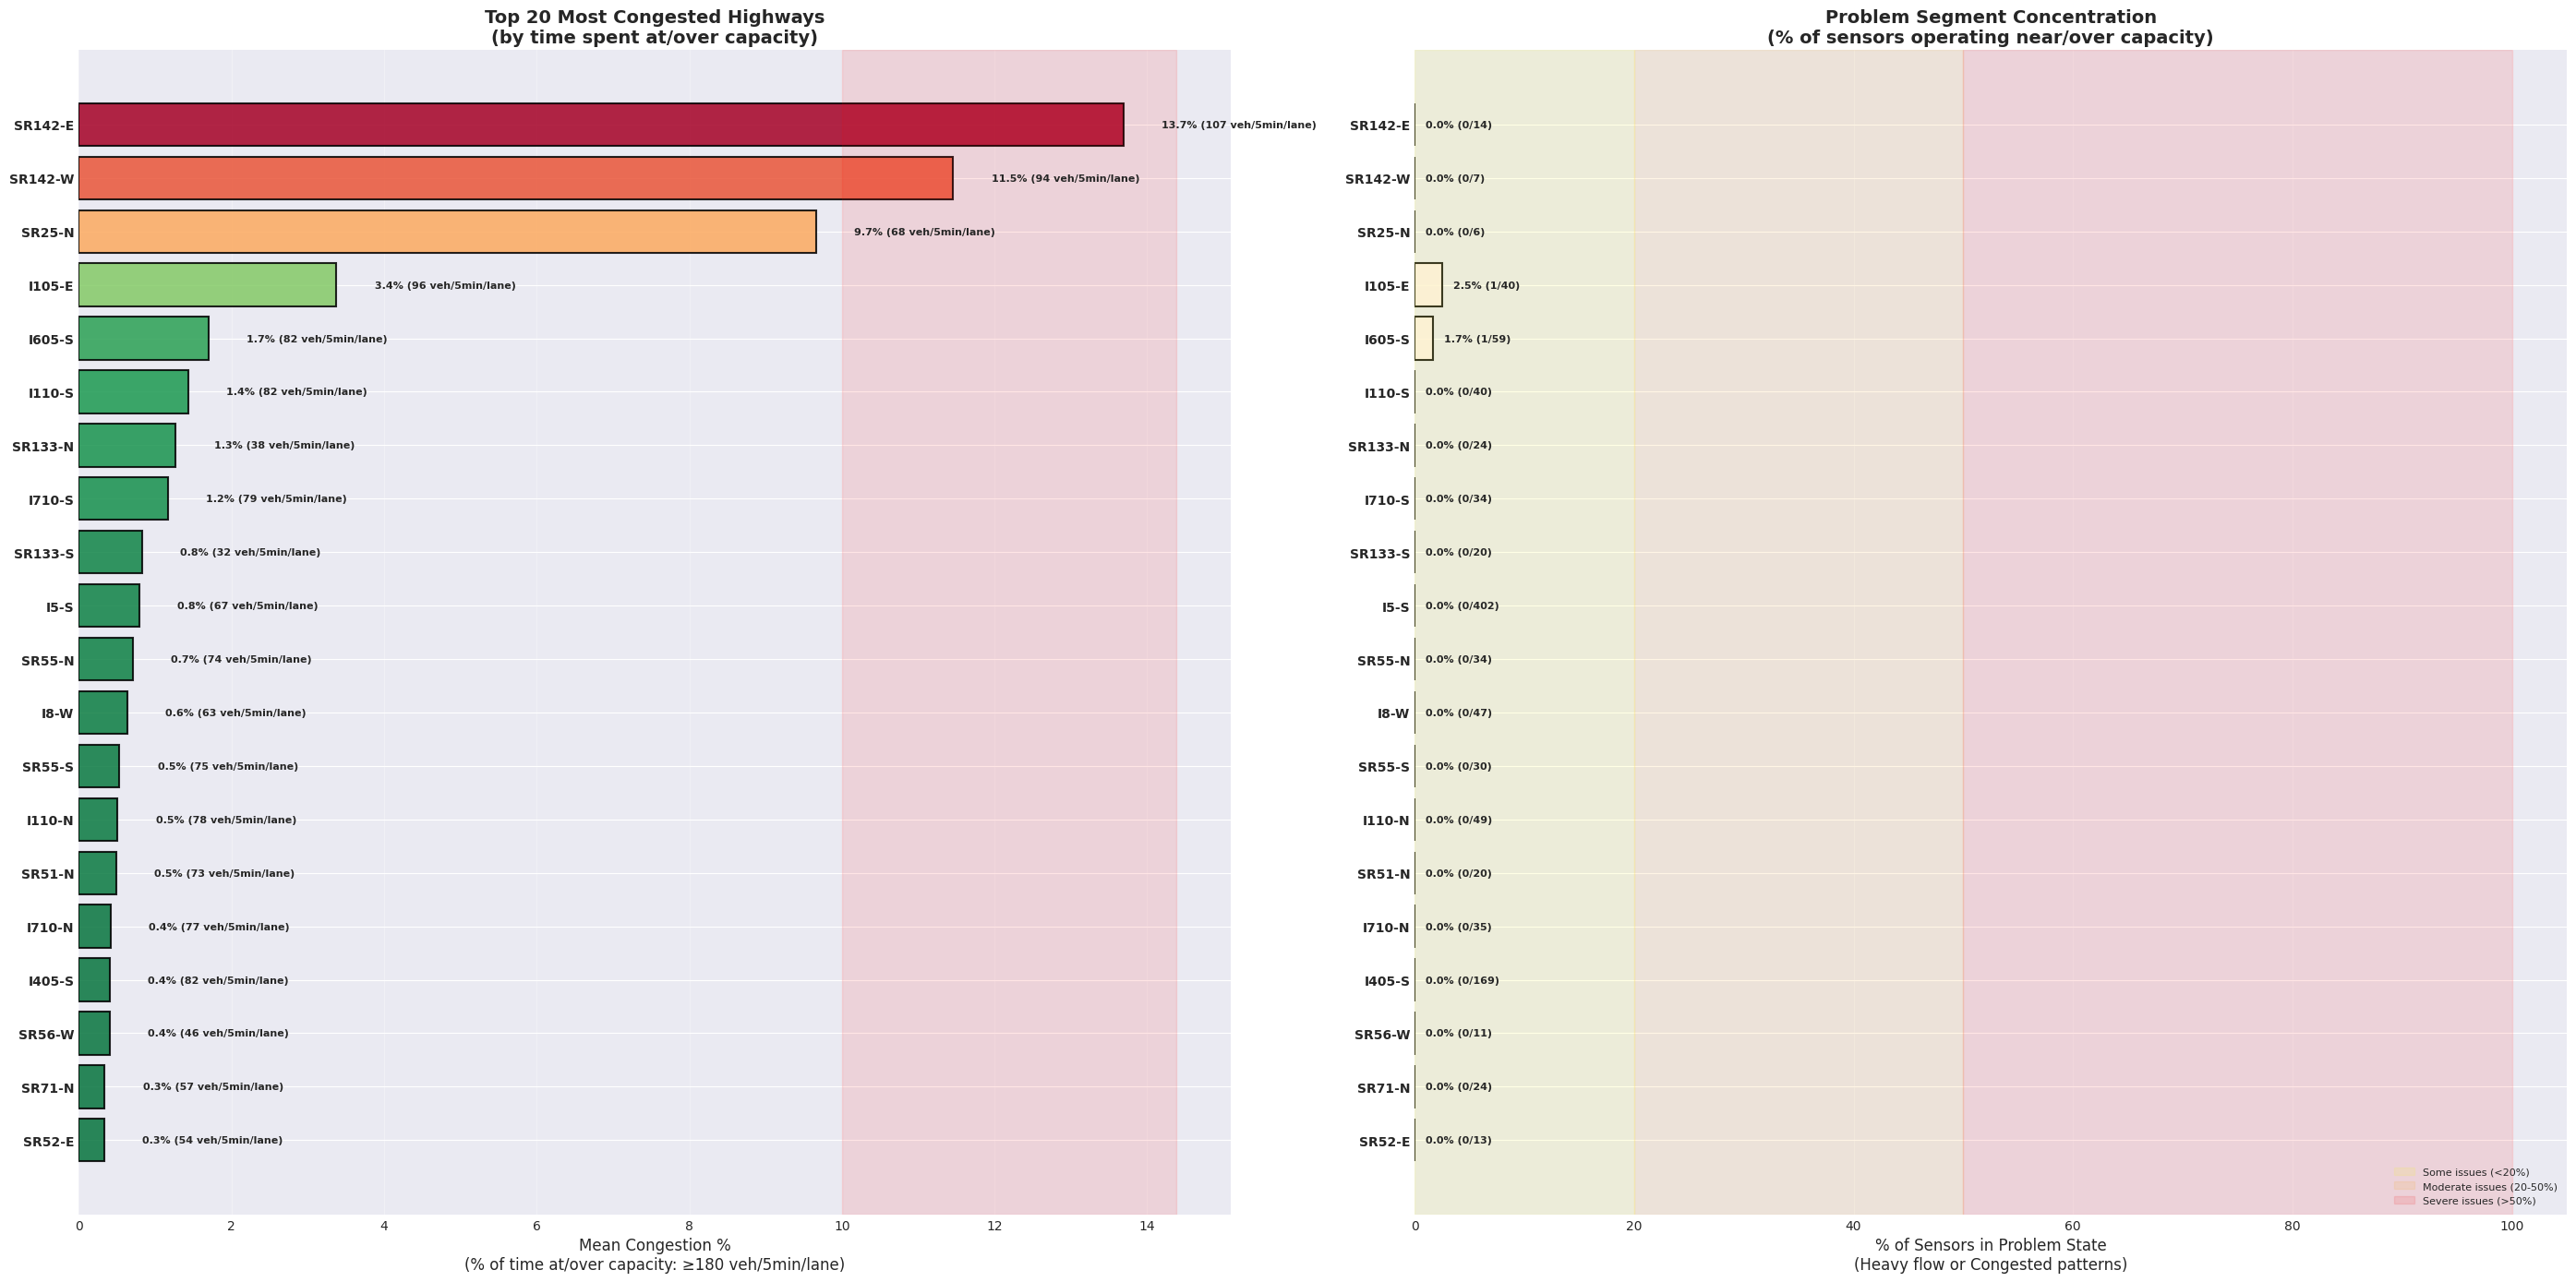


Highway congestion analysis complete

DETAILED ANALYSIS OF MOST CONGESTED HIGHWAYS:

TOP 5 WORST HIGHWAYS:

1. SR142-E
   Congestion: 13.7% of time at/over capacity
   Avg flow: 107.1 veh/5min/lane
   Capacity utilization: 59.5%
   Problem sensors: 0/14 (0.0%)

2. SR142-W
   Congestion: 11.5% of time at/over capacity
   Avg flow: 94.1 veh/5min/lane
   Capacity utilization: 52.3%
   Problem sensors: 0/7 (0.0%)

3. SR25-N
   Congestion: 9.7% of time at/over capacity
   Avg flow: 68.3 veh/5min/lane
   Capacity utilization: 38.0%
   Problem sensors: 0/6 (0.0%)

4. I105-E
   Congestion: 3.4% of time at/over capacity
   Avg flow: 95.6 veh/5min/lane
   Capacity utilization: 53.1%
   Problem sensors: 1/40 (2.5%)

5. I605-S
   Congestion: 1.7% of time at/over capacity
   Avg flow: 81.7 veh/5min/lane
   Capacity utilization: 45.4%
   Problem sensors: 1/59 (1.7%)

OVERALL HIGHWAY STATISTICS:

Total highways analyzed: 132
  Critical (>15% congested): 0 (0.0%)
  Warning (5-15% congested): 3 (2.3%)

In [39]:
print("Analyzing highways with highest traffic flow and congestion...")
print("="*100)
from pyspark.sql.functions import count as spark_count
highway_congestion = (
    traffic_categories
    .groupBy("Fwy")
    .agg(
        spark_count("*").alias("num_sensors"),
        avg("avg_flow_per_lane").alias("mean_flow_per_lane"),
        avg("flow_variance").alias("mean_variance"),
        avg("congestion_pct").alias("mean_congestion"),
        avg("heavy_flow_pct").alias("mean_heavy_flow"),
        spark_sum(when(
            col("traffic_pattern").isin(["Heavy & Stable", "Heavy & Variable", "Congested"]), 1
        ).otherwise(0)).alias("problem_sensors"),
        
        (avg("avg_flow_per_lane") / 180 * 100).alias("capacity_utilization_pct")
    )
    .filter(col("num_sensors") >= 5)
    .withColumn("pct_problem", col("problem_sensors") / col("num_sensors") * 100)
    .orderBy(col("mean_congestion").desc())
    .cache()
)

highway_congestion.write.mode("overwrite").parquet(f"{RESULTS_PATH}/highway_congestion_analysis")
print("Highway congestion analysis saved")

print("\nTOP 20 MOST CONGESTED HIGHWAYS:")
print("="*120)
print("(Ranked by % of time at/over capacity - ≥180 veh/5min/lane)")
print("="*120)

highway_congestion.select(
    "Fwy", "num_sensors", 
    "mean_flow_per_lane", "mean_variance",
    "mean_congestion", "capacity_utilization_pct",
    "problem_sensors", "pct_problem"
).show(20, truncate=False)

top20 = highway_congestion.limit(20).toPandas()

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(28, 14))

# Plot 1: Top 20 by congestion %
ax1 = axes[0]

# Color by severity (green to red gradient)
colors_map = plt.cm.RdYlGn_r(top20['mean_congestion'] / top20['mean_congestion'].max())
bars1 = ax1.barh(range(len(top20)), top20['mean_congestion'],
                 color=colors_map, edgecolor='black', alpha=0.85, linewidth=1.5)

ax1.set_yticks(range(len(top20)))
ax1.set_yticklabels(top20['Fwy'], fontsize=10, fontweight='bold')
ax1.set_xlabel('Mean Congestion %\n(% of time at/over capacity: ≥180 veh/5min/lane)', 
               fontsize=12)
ax1.set_title('Top 20 Most Congested Highways\n(by time spent at/over capacity)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels with flow info
for i, row in top20.iterrows():
    congestion = row['mean_congestion']
    flow = row['mean_flow_per_lane']
    ax1.text(congestion + 0.5, i, 
            f"{congestion:.1f}% ({flow:.0f} veh/5min/lane)",
            va='center', fontsize=8, fontweight='bold')

ax1.axvspan(10, ax1.get_xlim()[1], alpha=0.1, color='red', 
           label='High congestion (>10% of time)')

# Plot 2: Problem sensor concentration
ax2 = axes[1]

colors_map2 = plt.cm.Reds(top20['pct_problem'] / 100)
bars2 = ax2.barh(range(len(top20)), top20['pct_problem'],
                 color=colors_map2, edgecolor='black', alpha=0.85, linewidth=1.5)

ax2.set_yticks(range(len(top20)))
ax2.set_yticklabels(top20['Fwy'], fontsize=10, fontweight='bold')
ax2.set_xlabel('% of Sensors in Problem State\n(Heavy flow or Congested patterns)', 
               fontsize=12)
ax2.set_title('Problem Segment Concentration\n(% of sensors operating near/over capacity)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

for i, row in enumerate(top20.itertuples()):
    pct = row.pct_problem
    count = int(row.problem_sensors)
    total = int(row.num_sensors)
    ax2.text(pct + 1, i, 
            f'{pct:.1f}% ({count}/{total})',
            va='center', fontsize=8, fontweight='bold')

# Add severity zones
ax2.axvspan(0, 20, alpha=0.1, color='yellow', label='Some issues (<20%)')
ax2.axvspan(20, 50, alpha=0.1, color='orange', label='Moderate issues (20-50%)')
ax2.axvspan(50, 100, alpha=0.1, color='red', label='Severe issues (>50%)')
ax2.legend(fontsize=8, loc='lower right')

plt.tight_layout()
plt.savefig('top20_congested_highways.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHighway congestion analysis complete")

print("\n" + "="*100)
print("DETAILED ANALYSIS OF MOST CONGESTED HIGHWAYS:")
print("="*100)

# Get worst offenders
worst_5 = top20.head(5)

print("\nTOP 5 WORST HIGHWAYS:")
for idx, row in worst_5.iterrows():
    print(f"\n{idx+1}. {row['Fwy']}")
    print(f"   Congestion: {row['mean_congestion']:.1f}% of time at/over capacity")
    print(f"   Avg flow: {row['mean_flow_per_lane']:.1f} veh/5min/lane")
    print(f"   Capacity utilization: {row['capacity_utilization_pct']:.1f}%")
    print(f"   Problem sensors: {int(row['problem_sensors'])}/{int(row['num_sensors'])} ({row['pct_problem']:.1f}%)")
    
    # Diagnosis
    if row['capacity_utilization_pct'] > 100:
        print(f"   CRITICAL: Operating OVER capacity!")
    elif row['capacity_utilization_pct'] > 90:
        print(f"   WARNING: Near capacity, frequent congestion")
    elif row['capacity_utilization_pct'] > 80:
        print(f"   CAUTION: Heavy usage, approaching limits")
    
    if row['pct_problem'] > 50:
        print(f"   SYSTEMIC ISSUE: Majority of sensors show problems")
    elif row['pct_problem'] > 20:
        print(f"   Significant problem concentration")

print("\n" + "="*100)
print("OVERALL HIGHWAY STATISTICS:")
print("="*100)

all_highways = highway_congestion.count()
critical = highway_congestion.filter(col("mean_congestion") > 15).count()
warning = highway_congestion.filter(
    (col("mean_congestion") > 5) & (col("mean_congestion") <= 15)
).count()
normal = highway_congestion.filter(col("mean_congestion") <= 5).count()

print(f"\nTotal highways analyzed: {all_highways}")
print(f"  Critical (>15% congested): {critical} ({critical/all_highways*100:.1f}%)")
print(f"  Warning (5-15% congested): {warning} ({warning/all_highways*100:.1f}%)")
print(f"  Normal (<5% congested): {normal} ({normal/all_highways*100:.1f}%)")

print("\n" + "="*100)
print("RECOMMENDATIONS:")
print("="*100)

if critical > 0:
    print(f"\n1. IMMEDIATE ACTION NEEDED ({critical} highways):")
    critical_hwys = highway_congestion.filter(
        col("mean_congestion") > 15
    ).select("Fwy", "mean_congestion", "capacity_utilization_pct").toPandas()
    
    for _, row in critical_hwys.head(10).iterrows():
        print(f"   • {row['Fwy']:15s}: {row['mean_congestion']:5.1f}% congested, "
              f"{row['capacity_utilization_pct']:5.1f}% capacity utilization")
    
    print("\n   Actions:")
    print("   - Immediate capacity expansion or traffic management")
    print("   - Consider HOV lanes, ramp metering, variable speed limits")
    print("   - Encourage alternative routes or transit modes")

if warning > 0:
    print(f"\n2. MONITOR CLOSELY ({warning} highways):")
    print("   - Approaching capacity limits")
    print("   - Implement preventive traffic management")
    print("   - Plan for future capacity needs")

print(f"\n3. SYSTEM HEALTH:")
if normal/all_highways > 0.8:
    print("   Overall system is HEALTHY (>80% highways normal)")
elif normal/all_highways > 0.6:
    print("   System has SOME ISSUES (60-80% highways normal)")
else:
    print("   System is STRESSED (<60% highways normal)")

print("\n" + "="*100)

Analyzing traffic pattern distribution by highway...
Analyzing top 15 highways: US101-N, US101-S, I5-S, I5-N, SR99-N, SR99-S, I80-E, I10-W, I10-E, I80-W, I15-N, I15-S, I405-S, I405-N, I210-W


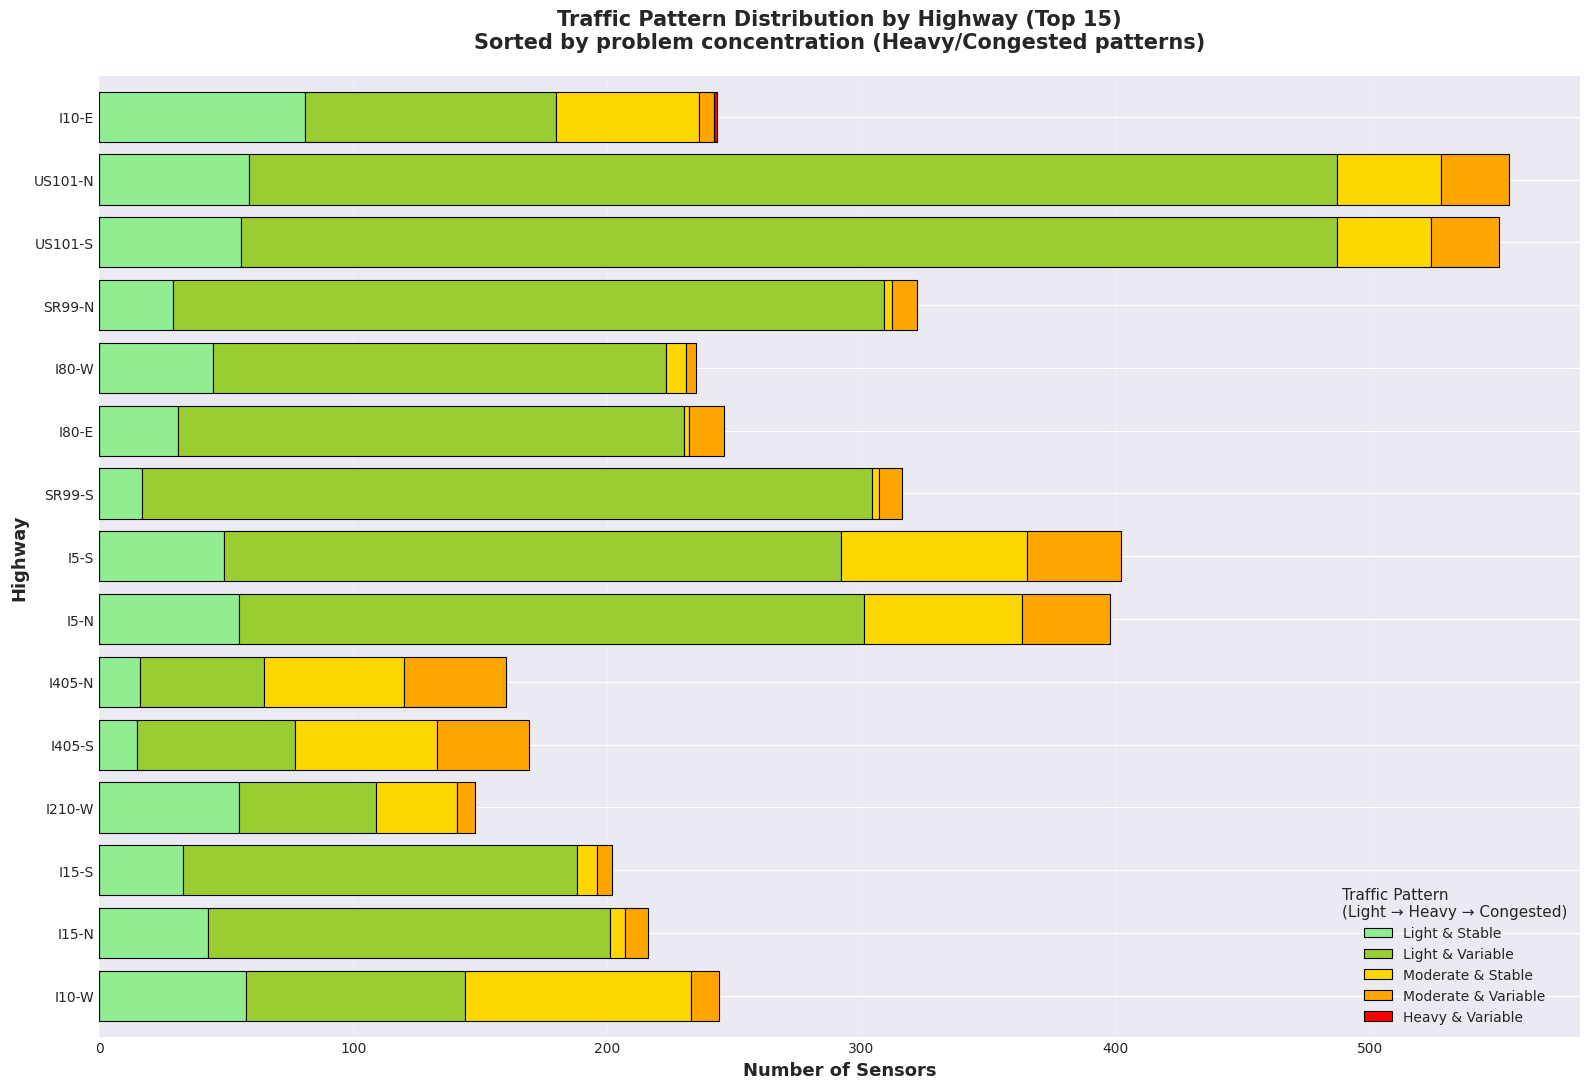


Highway pattern distribution complete

HIGHWAY PATTERN STATISTICS:

Highways ranked by problem concentration:
Highway  Total Sensors  Problem Sensors  Problem %  Dominant Pattern  Dominant %
  I10-E            243                1   0.411523  Light & Variable   40.740741
  I15-N            216                0   0.000000  Light & Variable   73.148148
  I10-W            244                0   0.000000 Moderate & Stable   36.475410
 I210-W            148                0   0.000000    Light & Stable   37.162162
 I405-S            169                0   0.000000  Light & Variable   36.686391
 I405-N            160                0   0.000000 Moderate & Stable   34.375000
  I15-S            202                0   0.000000  Light & Variable   76.732673
   I5-N            398                0   0.000000  Light & Variable   61.809045
   I5-S            402                0   0.000000  Light & Variable   60.447761
  I80-E            246                0   0.000000  Light & Variable   80.89430

In [28]:
print("Analyzing traffic pattern distribution by highway...")
print("="*100)

# Get top 15 highways by sensor count
top_highways = (
    traffic_categories
    .groupBy("Fwy")
    .count()
    .orderBy(col("count").desc())
    .limit(15)
    .select("Fwy")
).toPandas()['Fwy'].tolist()

print(f"Analyzing top 15 highways: {', '.join(top_highways)}")

# Get pattern distribution for these highways
highway_patterns = (
    traffic_categories
    .filter(col("Fwy").isin(top_highways))
    .groupBy("Fwy", "traffic_pattern")
    .count()
).toPandas()

highway_pivot = highway_patterns.pivot(
    index='Fwy',
    columns='traffic_pattern',
    values='count'
).fillna(0)

# Define pattern order (light to heavy/congested)
pattern_order = [
    'Light & Stable', 
    'Light & Variable', 
    'Moderate & Stable', 
    'Moderate & Variable', 
    'Heavy & Stable',
    'Heavy & Variable',
    'Congested'
]

highway_pivot = highway_pivot[[col for col in pattern_order if col in highway_pivot.columns]]

# Sort highways by problem concentration (Heavy + Congested patterns)
problem_cols = [col for col in ['Heavy & Stable', 'Heavy & Variable', 'Congested'] 
                if col in highway_pivot.columns]
if problem_cols:
    highway_pivot['_problem_total'] = highway_pivot[problem_cols].sum(axis=1)
    highway_pivot = highway_pivot.sort_values('_problem_total', ascending=True)
    highway_pivot = highway_pivot.drop('_problem_total', axis=1)

fig, ax = plt.subplots(figsize=(16, 11))

pattern_colors = {
    'Light & Stable': 'lightgreen',
    'Light & Variable': 'yellowgreen',
    'Moderate & Stable': 'gold',
    'Moderate & Variable': 'orange',
    'Heavy & Stable': 'orangered',
    'Heavy & Variable': 'red',
    'Congested': 'darkred',
    'Other': 'gray'
}

colors = [pattern_colors.get(col, 'gray') for col in highway_pivot.columns]


highway_pivot.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    linewidth=0.8,
    width=0.8
)

ax.set_xlabel('Number of Sensors', fontsize=13, fontweight='bold')
ax.set_ylabel('Highway', fontsize=13, fontweight='bold')
ax.set_title('Traffic Pattern Distribution by Highway (Top 15)\n' + 
             'Sorted by problem concentration (Heavy/Congested patterns)',
             fontsize=15, fontweight='bold', pad=20)

# Customize legend
ax.legend(
    title='Traffic Pattern\n(Light → Heavy → Congested)', 
    fontsize=10, 
    loc='lower right',
    title_fontsize=11,
    framealpha=0.95,
    edgecolor='black'
)

ax.grid(True, alpha=0.3, axis='x')

# Add highway labels with emphasis on problem areas
for i, (idx, row) in enumerate(highway_pivot.iterrows()):
    total_sensors = row.sum()
    
    # Calculate problem percentage
    problem_count = sum(row[col] for col in problem_cols if col in row.index)
    problem_pct = (problem_count / total_sensors * 100) if total_sensors > 0 else 0
    
    # Highlight highways with significant problems
    if problem_pct > 50:
        ax.get_yticklabels()[i].set_color('darkred')
        ax.get_yticklabels()[i].set_weight('bold')
        ax.get_yticklabels()[i].set_size(11)
    elif problem_pct > 20:
        ax.get_yticklabels()[i].set_color('red')
        ax.get_yticklabels()[i].set_weight('bold')
        ax.get_yticklabels()[i].set_size(10)


for i, (idx, row) in enumerate(highway_pivot.iterrows()):
    total = row.sum()
    problem_count = sum(row[col] for col in problem_cols if col in row.index)
    problem_pct = (problem_count / total * 100) if total > 0 else 0
    
    if problem_pct > 30:  # Annotate if >30% problem sensors
        ax.text(
            total + 2, i, 
            f'{problem_pct:.0f}% problem',
            va='center', 
            fontsize=8, 
            fontweight='bold',
            color='darkred',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='darkred')
        )

plt.tight_layout()
plt.savefig('highway_pattern_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHighway pattern distribution complete")

print("\n" + "="*100)
print("HIGHWAY PATTERN STATISTICS:")
print("="*100)

# Calculate statistics for each highway
highway_stats = []
for highway in highway_pivot.index:
    row = highway_pivot.loc[highway]
    total = row.sum()
    problem_count = sum(row[col] for col in problem_cols if col in row.index)
    problem_pct = (problem_count / total * 100) if total > 0 else 0
    
    # Get dominant pattern
    dominant_pattern = row.idxmax()
    dominant_count = row.max()
    dominant_pct = (dominant_count / total * 100) if total > 0 else 0
    
    highway_stats.append({
        'Highway': highway,
        'Total Sensors': int(total),
        'Problem Sensors': int(problem_count),
        'Problem %': problem_pct,
        'Dominant Pattern': dominant_pattern,
        'Dominant %': dominant_pct
    })

highway_stats_df = pd.DataFrame(highway_stats).sort_values('Problem %', ascending=False)

print("\nHighways ranked by problem concentration:")
print(highway_stats_df.to_string(index=False))

# Identify patterns
print("\n" + "="*100)
print("KEY OBSERVATIONS:")
print("="*100)

# Most problematic
most_problem = highway_stats_df.iloc[0]
print(f"\n1. MOST PROBLEMATIC HIGHWAY: {most_problem['Highway']}")
print(f"   - {most_problem['Problem %']:.1f}% of sensors in problem state")
print(f"   - {int(most_problem['Problem Sensors'])}/{int(most_problem['Total Sensors'])} sensors")

# Healthiest
healthiest = highway_stats_df.iloc[-1]
print(f"\n2. HEALTHIEST HIGHWAY: {healthiest['Highway']}")
print(f"   - Only {healthiest['Problem %']:.1f}% problem sensors")
print(f"   - Dominant pattern: {healthiest['Dominant Pattern']} ({healthiest['Dominant %']:.1f}%)")

# Overall patterns
print(f"\n3. COMMON PATTERNS:")
pattern_freq = highway_stats_df['Dominant Pattern'].value_counts()
for pattern, count in pattern_freq.items():
    print(f"   - {pattern}: {count} highways")

# Critical highways
critical_hwys = highway_stats_df[highway_stats_df['Problem %'] > 50]
if len(critical_hwys) > 0:
    print(f"\n4. CRITICAL HIGHWAYS (>50% problem sensors): {len(critical_hwys)}")
    for _, row in critical_hwys.iterrows():
        print(f"   🚨 {row['Highway']}: {row['Problem %']:.1f}% problem")
else:
    print(f"\n4. No highways have >50% problem sensors (good system health)")

print("\n" + "="*100)

Creating spatial visualization of traffic patterns...
Visualizing 2,562 sensors (30% sample)


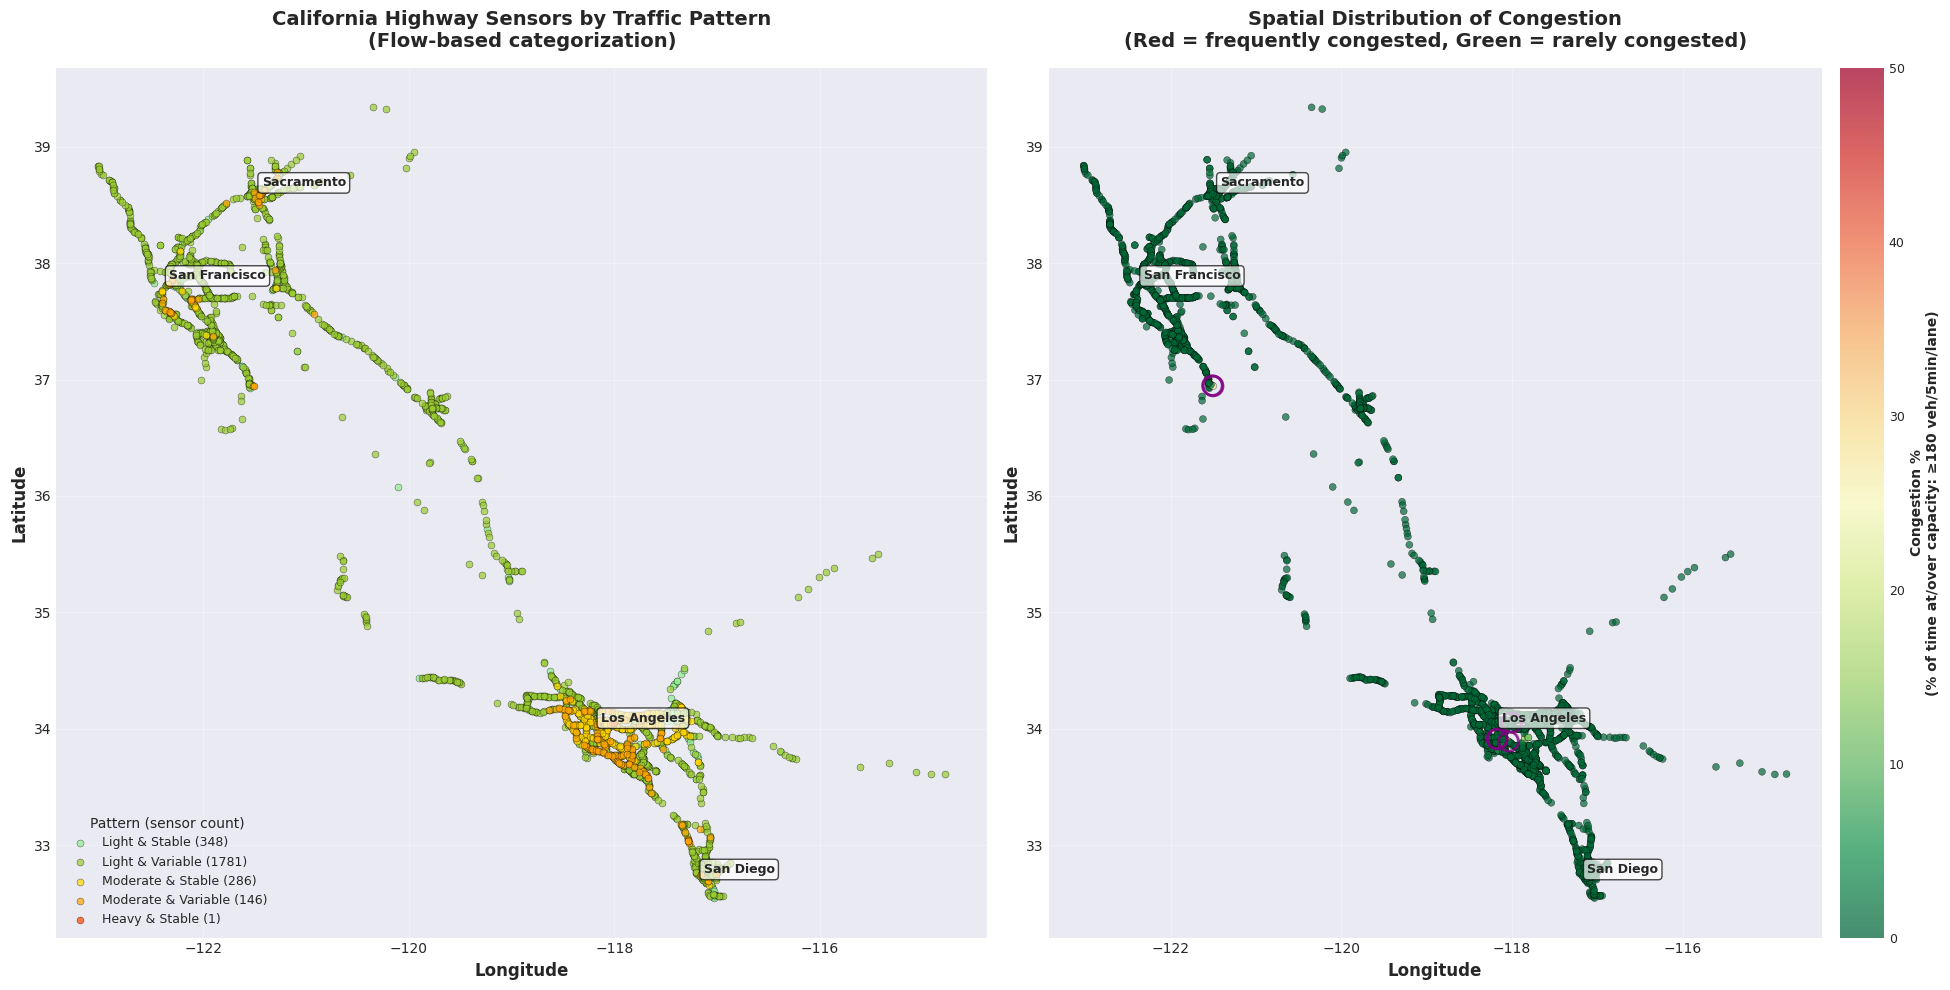


✓ Spatial visualization complete

GEOGRAPHIC ANALYSIS:

Traffic Patterns by Region:
----------------------------------------------------------------------------------------------------
                congestion_pct  avg_flow_per_lane   traffic_pattern  sensor_count
region                                                                           
Central Valley             0.5               47.3  Light & Variable           128
LA Metro                   0.3               68.2  Light & Variable          1136
Orange County              0.3               70.3  Light & Variable            13
San Diego                  0.1               58.5  Light & Variable           218
Bay Area                   0.0               59.6  Light & Variable           645
Central Coast              0.0               47.5  Light & Variable             1
Northern CA                0.0               56.9  Light & Variable           358
Other                      0.0               43.0  Light & Variable         

In [33]:
print("Creating spatial visualization of traffic patterns...")
print("="*100)

# Sample for visualization (30% of sensors)
sample = traffic_categories.sample(0.3, seed=42).toPandas()
print(f"Visualizing {len(sample):,} sensors (30% sample)")

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# ==================== Plot 1: Colored by traffic pattern ====================
ax1 = axes[0]

# Define colors (light to heavy/congested gradient)
pattern_colors = {
    'Light & Stable': 'lightgreen',
    'Light & Variable': 'yellowgreen',
    'Moderate & Stable': 'gold',
    'Moderate & Variable': 'orange',
    'Heavy & Stable': 'orangered',
    'Heavy & Variable': 'red',
    'Congested': 'darkred',
    'Other': 'gray'
}

for pattern, color in pattern_colors.items():
    data = sample[sample['traffic_pattern'] == pattern]
    if len(data) > 0:
        ax1.scatter(
            data['Lng'], data['Lat'],
            c=color, label=f"{pattern} ({len(data)})",
            s=25, alpha=0.7,
            edgecolors='black', linewidth=0.3
        )

ax1.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax1.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax1.set_title('California Highway Sensors by Traffic Pattern\n' +
             '(Flow-based categorization)',
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=9, loc='lower left', framealpha=0.95, 
          title='Pattern (sensor count)', title_fontsize=10)
ax1.grid(True, alpha=0.3)

cities = {
    'San Francisco': (-122.4, 37.8),
    'Los Angeles': (-118.2, 34.0),
    'San Diego': (-117.2, 32.7),
    'Sacramento': (-121.5, 38.6)
}

for city, (lng, lat) in cities.items():
    ax1.annotate(city, xy=(lng, lat), xytext=(5, 5),
                textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         alpha=0.7, edgecolor='black'),
                fontweight='bold')

# ==================== Plot 2: Colored by congestion % ====================
ax2 = axes[1]

# Create scatter plot with congestion coloring
scatter = ax2.scatter(
    sample['Lng'], sample['Lat'],
    c=sample['congestion_pct'],
    s=25, 
    cmap='RdYlGn_r',  # Red = high congestion, Green = low
    alpha=0.7,
    edgecolors='black', 
    linewidth=0.3,
    vmin=0, 
    vmax=50 
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax2, pad=0.02)
cbar.set_label('Congestion %\n(% of time at/over capacity: ≥180 veh/5min/lane)', 
              fontsize=10, fontweight='bold')
cbar.ax.tick_params(labelsize=9)

ax2.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax2.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax2.set_title('Spatial Distribution of Congestion\n' +
             '(Red = frequently congested, Green = rarely congested)',
             fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)

for city, (lng, lat) in cities.items():
    ax2.annotate(city, xy=(lng, lat), xytext=(5, 5),
                textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         alpha=0.7, edgecolor='black'),
                fontweight='bold')

# Highlight most congested areas with circles
top_congested = sample.nlargest(10, 'congestion_pct')
for _, row in top_congested.iterrows():
    if row['congestion_pct'] > 20:  # Only highlight if >20% congested
        ax2.scatter(row['Lng'], row['Lat'], 
                   s=200, facecolors='none', 
                   edgecolors='purple', linewidth=2, alpha=0.8)

plt.tight_layout()
plt.savefig('spatial_traffic_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Spatial visualization complete")

# Geographic analysis
print("\n" + "="*100)
print("GEOGRAPHIC ANALYSIS:")
print("="*100)

regions = {
    'Northern CA': {'lat_min': 38.0, 'lat_max': 42.0},
    'Bay Area': {'lat_min': 37.0, 'lat_max': 38.0},
    'Central Valley': {'lat_min': 35.5, 'lat_max': 37.0, 'lng_min': -122.0},
    'Central Coast': {'lat_min': 35.5, 'lat_max': 37.0, 'lng_max': -122.0},
    'LA Metro': {'lat_min': 33.5, 'lat_max': 34.5},
    'Orange County': {'lat_min': 33.4, 'lat_max': 33.9, 'lng_min': -118.1},
    'Inland Empire': {'lat_min': 33.5, 'lat_max': 34.5, 'lng_min': -118.0, 'lng_max': -117.0},
    'San Diego': {'lat_min': 32.5, 'lat_max': 33.4}
}

# Assign regions to sample
def assign_region(row):
    for region, bounds in regions.items():
        lat_match = bounds.get('lat_min', -90) <= row['Lat'] <= bounds.get('lat_max', 90)
        lng_match = (bounds.get('lng_min', -180) <= row['Lng'] <= bounds.get('lng_max', 180) 
                    if 'lng_min' in bounds or 'lng_max' in bounds else True)
        if lat_match and lng_match:
            return region
    return 'Other'

sample['region'] = sample.apply(assign_region, axis=1)

# Regional statistics
print("\nTraffic Patterns by Region:")
print("-" * 100)

regional_stats = sample.groupby('region').agg({
    'congestion_pct': 'mean',
    'avg_flow_per_lane': 'mean',
    'traffic_pattern': lambda x: x.mode()[0] if len(x) > 0 else 'N/A'
}).round(1)

regional_stats['sensor_count'] = sample.groupby('region').size()
regional_stats = regional_stats.sort_values('congestion_pct', ascending=False)

print(regional_stats.to_string())

# Identify hot spots
print("\n" + "="*100)
print("CONGESTION HOT SPOTS:")
print("="*100)

hot_spots = sample[sample['congestion_pct'] > 15].sort_values('congestion_pct', ascending=False)

if len(hot_spots) > 0:
    print(f"\nFound {len(hot_spots)} sensors with >15% congestion:")
    print("\nTop 10 most congested locations:")
    for idx, (_, row) in enumerate(hot_spots.head(10).iterrows(), 1):
        print(f"{idx:2d}. {row['Fwy']:10s} @ ({row['Lat']:.4f}, {row['Lng']:.4f}) - "
              f"{row['congestion_pct']:5.1f}% congested, "
              f"{row['avg_flow_per_lane']:5.1f} veh/5min/lane")
else:
    print("✓ No severe congestion hot spots found (all sensors <15% congestion)")

# Pattern distribution by region
print("\n" + "="*100)
print("DOMINANT PATTERNS BY REGION:")
print("="*100)

for region in regional_stats.index:
    region_data = sample[sample['region'] == region]
    pattern_dist = region_data['traffic_pattern'].value_counts()
    total = len(region_data)
    
    print(f"\n{region}:")
    for pattern, count in pattern_dist.head(3).items():
        pct = count / total * 100
        print(f"  • {pattern:25s}: {count:3d} sensors ({pct:5.1f}%)")

print("\n" + "="*100)

In [40]:
print("="*100)
print("PEAK-HOUR TRAFFIC ANALYSIS")
print("="*100)
print("\nThis analysis separates peak hours from off-peak to reveal true congestion patterns.")
print("24-hour averages mask rush-hour congestion by including empty nighttime roads.")

PEAK-HOUR TRAFFIC ANALYSIS

This analysis separates peak hours from off-peak to reveal true congestion patterns.
24-hour averages mask rush-hour congestion by including empty nighttime roads.


In [41]:
clean_df_with_hour = clean_df.withColumn("hour", hour("timestamp"))
clean_df_with_hour = clean_df_with_hour.withColumn("day_of_week", dayofweek("timestamp"))

In [42]:
clean_df_with_hour = clean_df_with_hour.withColumn(
    "time_period",
    when(
        (col("day_of_week").isin([1, 7])),  # Saturday=7, Sunday=1
        "Weekend"
    ).when(
        col("hour").isin([7, 8, 16, 17, 18]), 
        "Weekday_Peak"
    ).otherwise("Weekday_OffPeak")
)


In [43]:
period_counts = clean_df_with_hour.groupBy("time_period").count().toPandas()
print("\nData distribution by time period:")
print(period_counts.to_string(index=False))

[Stage 256:======================================================>(84 + 1) / 85]


Data distribution by time period:
    time_period      count
   Weekday_Peak  655989937
Weekday_OffPeak 2493221723
        Weekend 1256873527


In [44]:
print("\n" + "="*100)
print("COMPUTING FLOW STATISTICS BY TIME PERIOD")
print("="*100)

sensor_stats_by_period = (
    clean_df_with_hour
    .groupBy("sensor_id", "Fwy", "County", "Lat", "Lng", "Lanes", "Type", "Direction", "time_period")
    .agg(
        avg("value").alias("avg_flow_total"),
        (avg("value") / col("Lanes")).alias("avg_flow_per_lane"),
        stddev("value").alias("flow_variance"),
        spark_count("*").alias("num_readings"),
        
        # Congestion metrics
        (spark_sum(when(col("value") / col("Lanes") >= 180, 1).otherwise(0)) / spark_count("*") * 100)
            .alias("congestion_pct"),
        (spark_sum(when(col("value") / col("Lanes") >= 200, 1).otherwise(0)) / spark_count("*") * 100)
            .alias("severe_congestion_pct"),
        (spark_sum(when(col("value") / col("Lanes") < 30, 1).otherwise(0)) / spark_count("*") * 100)
            .alias("low_flow_pct")
    )
    .filter(col("num_readings") > 100)  # At least 100 readings per period
    .cache()
)
sensor_stats_by_period.write.mode("overwrite").parquet(
    f"{RESULTS_PATH}/sensor_statistics_by_period"
)


COMPUTING FLOW STATISTICS BY TIME PERIOD


In [45]:
print("\n" + "="*100)
print("PEAK VS OFF-PEAK COMPARISON")
print("="*100)


PEAK VS OFF-PEAK COMPARISON


In [46]:
period_stats = (
    sensor_stats_by_period
    .groupBy("time_period")
    .agg(
        spark_count("*").alias("num_sensors"),
        avg("avg_flow_per_lane").alias("mean_flow_per_lane"),
        avg("flow_variance").alias("mean_variance"),
        avg("congestion_pct").alias("mean_congestion"),
        avg("severe_congestion_pct").alias("mean_severe_congestion"),
        avg("low_flow_pct").alias("mean_low_flow")
    )
    .orderBy("time_period")
)

print("\nSystem-wide statistics by time period:")
period_stats.show(truncate=False)

period_stats_df = period_stats.toPandas()

# Calculate capacity utilization
period_stats_df['capacity_utilization'] = (period_stats_df['mean_flow_per_lane'] / 180 * 100)

print("\nCapacity Utilization by Period:")
for _, row in period_stats_df.iterrows():
    print(f"{row['time_period']:20s}: {row['capacity_utilization']:5.1f}% "
          f"({row['mean_flow_per_lane']:5.1f} veh/5min/lane)")


System-wide statistics by time period:
+---------------+-----------+------------------+------------------+-------------------+----------------------+------------------+
|time_period    |num_sensors|mean_flow_per_lane|mean_variance     |mean_congestion    |mean_severe_congestion|mean_low_flow     |
+---------------+-----------+------------------+------------------+-------------------+----------------------+------------------+
|Weekday_OffPeak|8600       |57.296431444424684|127.18553190640856|0.19071034682543922|0.08231863488572032   |33.37278303845538 |
|Weekday_Peak   |8600       |90.36106166389216 |81.84487488242792 |0.4068414080632342 |0.16881689667762934   |4.159600535342905 |
|Weekend        |8600       |57.35473917562784 |119.50161295855662|0.1943325533565542 |0.08119722293506763   |31.321228464142944|
+---------------+-----------+------------------+------------------+-------------------+----------------------+------------------+


Capacity Utilization by Period:
Weekday_OffPeak 


CREATING PEAK VS OFF-PEAK VISUALIZATIONS


/tmp/ipykernel_190295/3534984636.py:83: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


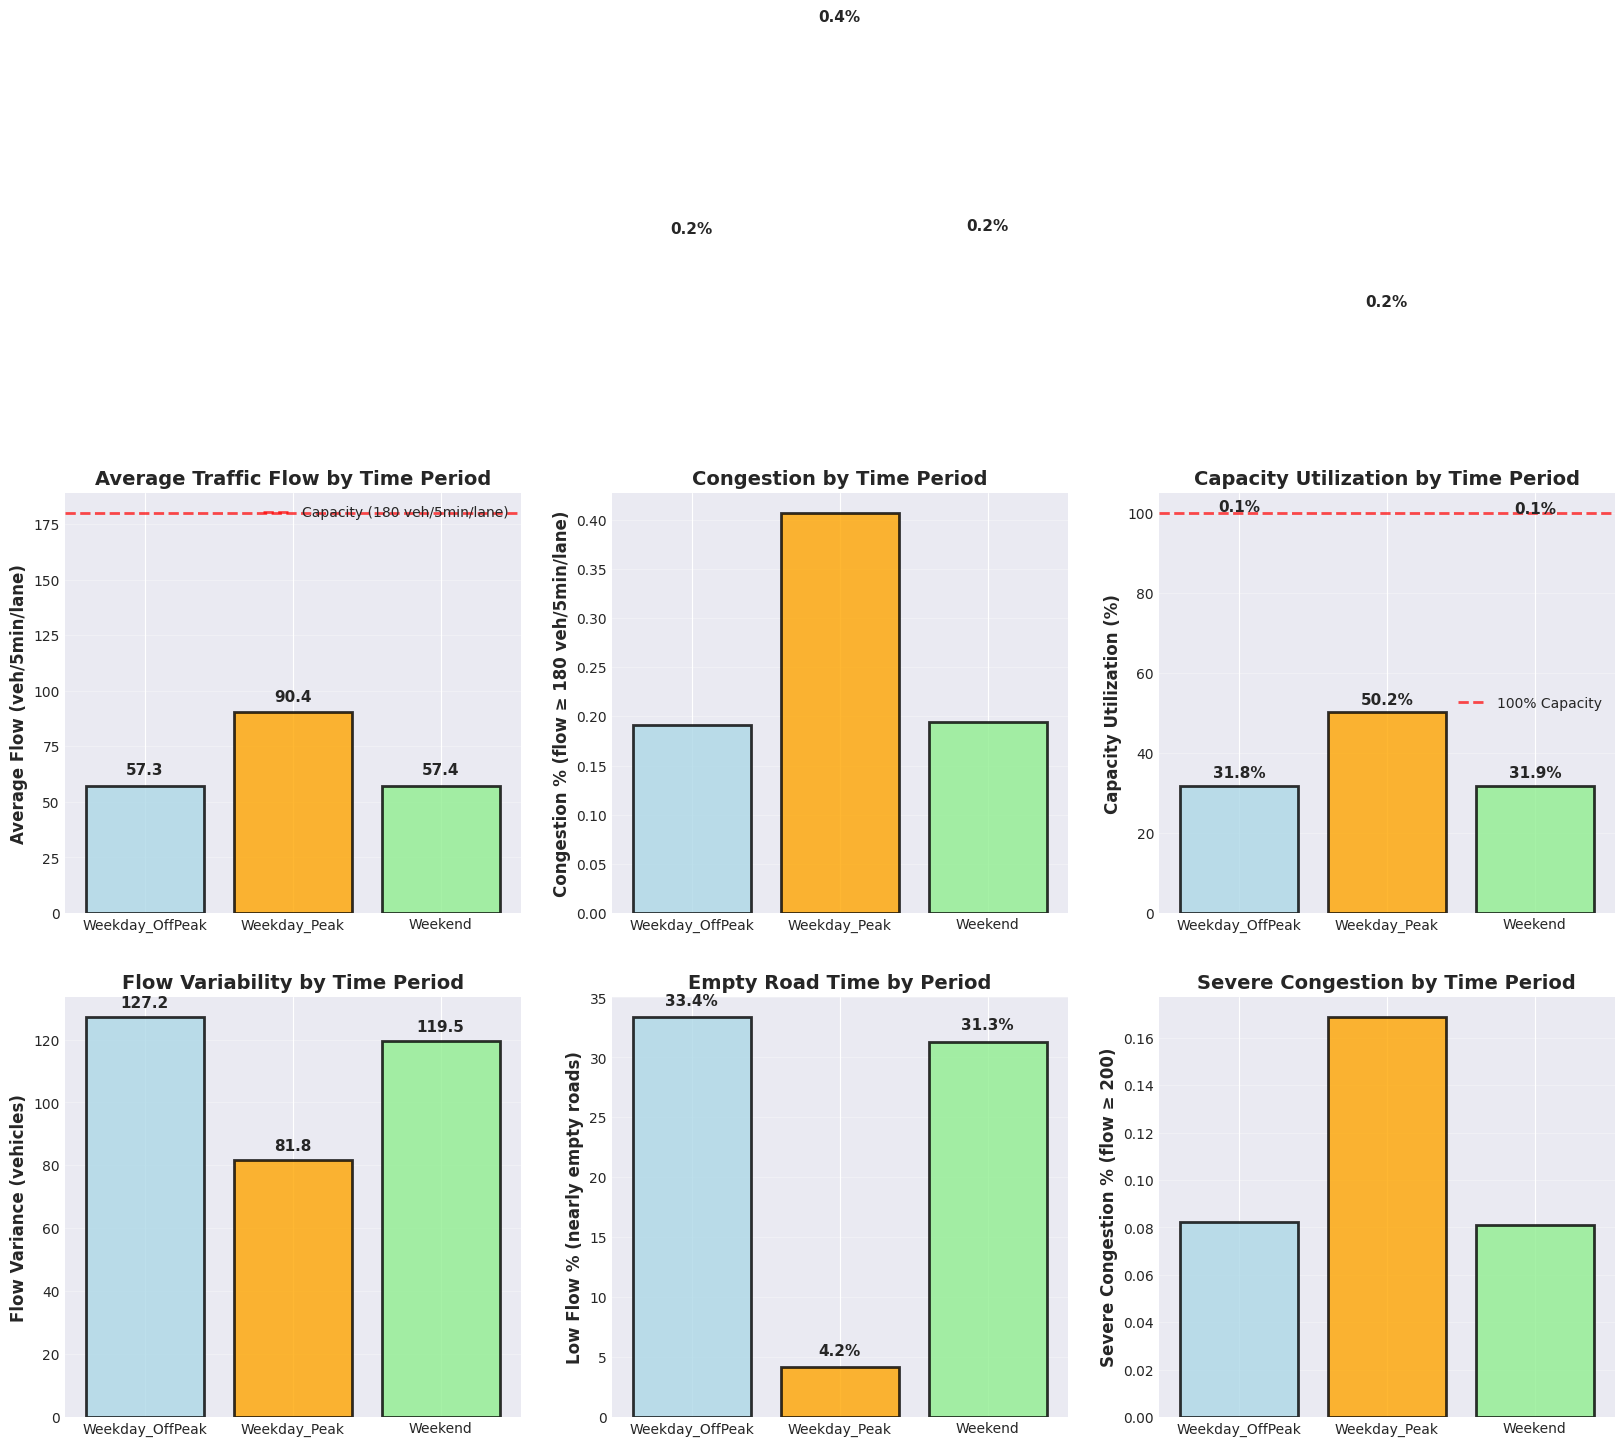

 Peak vs off-peak comparison plot saved


In [47]:
print("\n" + "="*100)
print("CREATING PEAK VS OFF-PEAK VISUALIZATIONS")
print("="*100)

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Flow per lane comparison
ax1 = axes[0, 0]
colors = ['lightblue', 'orange', 'lightgreen']
bars1 = ax1.bar(period_stats_df['time_period'], period_stats_df['mean_flow_per_lane'],
                color=colors, edgecolor='black', alpha=0.8, linewidth=2)
ax1.axhline(y=180, color='red', linestyle='--', linewidth=2, alpha=0.7,
           label='Capacity (180 veh/5min/lane)')
ax1.set_ylabel('Average Flow (veh/5min/lane)', fontsize=12, fontweight='bold')
ax1.set_title('Average Traffic Flow by Time Period', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(period_stats_df['mean_flow_per_lane']):
    ax1.text(i, v + 5, f'{v:.1f}', ha='center', fontsize=11, fontweight='bold')

# Plot 2: Congestion % comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(period_stats_df['time_period'], period_stats_df['mean_congestion'],
                color=colors, edgecolor='black', alpha=0.8, linewidth=2)
ax2.set_ylabel('Congestion % (flow ≥ 180 veh/5min/lane)', fontsize=12, fontweight='bold')
ax2.set_title('Congestion by Time Period', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(period_stats_df['mean_congestion']):
    ax2.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Plot 3: Capacity utilization
ax3 = axes[0, 2]
bars3 = ax3.bar(period_stats_df['time_period'], period_stats_df['capacity_utilization'],
                color=colors, edgecolor='black', alpha=0.8, linewidth=2)
ax3.axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.7,
           label='100% Capacity')
ax3.set_ylabel('Capacity Utilization (%)', fontsize=12, fontweight='bold')
ax3.set_title('Capacity Utilization by Time Period', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(period_stats_df['capacity_utilization']):
    ax3.text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Plot 4: Variance comparison
ax4 = axes[1, 0]
bars4 = ax4.bar(period_stats_df['time_period'], period_stats_df['mean_variance'],
                color=colors, edgecolor='black', alpha=0.8, linewidth=2)
ax4.set_ylabel('Flow Variance (vehicles)', fontsize=12, fontweight='bold')
ax4.set_title('Flow Variability by Time Period', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(period_stats_df['mean_variance']):
    ax4.text(i, v + 3, f'{v:.1f}', ha='center', fontsize=11, fontweight='bold')

# Plot 5: Low flow % comparison
ax5 = axes[1, 1]
bars5 = ax5.bar(period_stats_df['time_period'], period_stats_df['mean_low_flow'],
                color=colors, edgecolor='black', alpha=0.8, linewidth=2)
ax5.set_ylabel('Low Flow % (nearly empty roads)', fontsize=12, fontweight='bold')
ax5.set_title('Empty Road Time by Period', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(period_stats_df['mean_low_flow']):
    ax5.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Plot 6: Severe congestion comparison
ax6 = axes[1, 2]
bars6 = ax6.bar(period_stats_df['time_period'], period_stats_df['mean_severe_congestion'],
                color=colors, edgecolor='black', alpha=0.8, linewidth=2)
ax6.set_ylabel('Severe Congestion % (flow ≥ 200)', fontsize=12, fontweight='bold')
ax6.set_title('Severe Congestion by Time Period', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(period_stats_df['mean_severe_congestion']):
    ax6.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('peak_vs_offpeak_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Peak vs off-peak comparison plot saved")


REGIONAL PEAK-HOUR ANALYSIS

Regional analysis by time period:
+-------------+---------------+-----------+------------------+---------------------+--------------------+
|County       |time_period    |num_sensors|mean_flow_per_lane|mean_congestion      |capacity_utilization|
+-------------+---------------+-----------+------------------+---------------------+--------------------+
|Alameda      |Weekday_OffPeak|479        |60.92812707714843 |0.020045666465138036 |33.84895948730468   |
|Alameda      |Weekday_Peak   |479        |91.67495104033372 |0.03212518769913832  |50.930528355740954  |
|Alameda      |Weekend        |479        |61.59893955982059 |0.01798444304477997  |34.22163308878922   |
|Los Angeles  |Weekday_OffPeak|1728       |72.29616539885699 |0.4931570560574582   |40.164536332698326  |
|Los Angeles  |Weekday_Peak   |1728       |105.57667071783557|0.978853628638981    |58.6537059543531    |
|Los Angeles  |Weekend        |1728       |73.24259232234222 |0.5578340374352899   |40.6

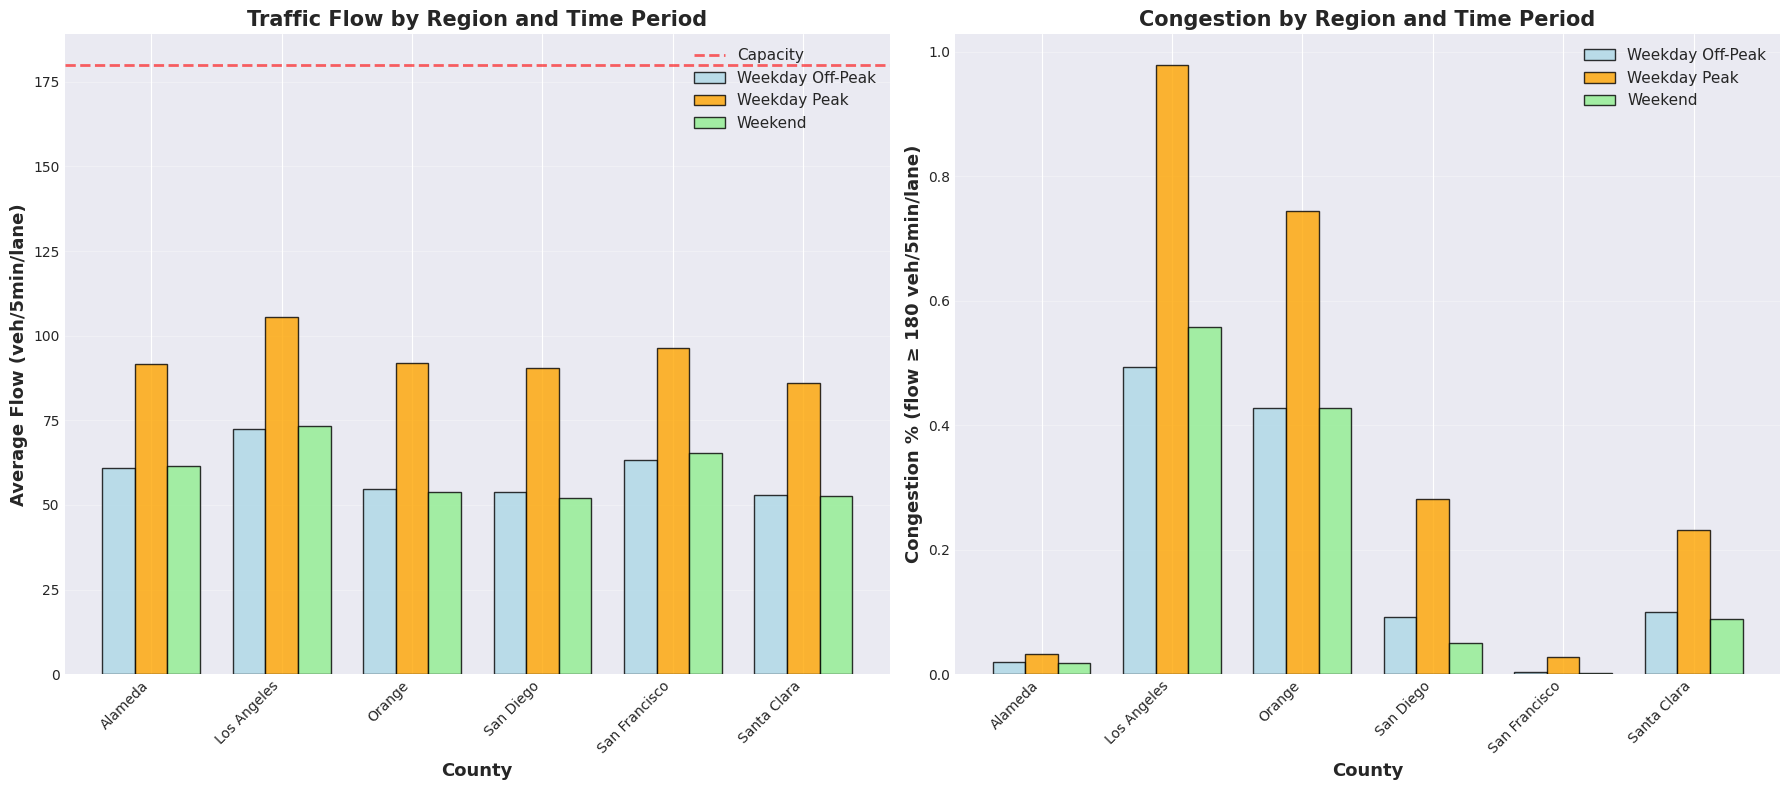

 Regional peak analysis plot saved


In [48]:
print("\n" + "="*100)
print("REGIONAL PEAK-HOUR ANALYSIS")
print("="*100)
major_counties = ['Los Angeles', 'Orange', 'San Diego', 'Alameda', 'Santa Clara', 'San Francisco']

regional_peak_analysis = (
    sensor_stats_by_period
    .filter(col("County").isin(major_counties))
    .groupBy("County", "time_period")
    .agg(
        spark_count("*").alias("num_sensors"),
        avg("avg_flow_per_lane").alias("mean_flow_per_lane"),
        avg("congestion_pct").alias("mean_congestion"),
        (avg("avg_flow_per_lane") / 180 * 100).alias("capacity_utilization")
    )
    .orderBy("County", "time_period")
)

print("\nRegional analysis by time period:")
regional_peak_analysis.show(100, truncate=False)

# Pivot for visualization
regional_peak_df = regional_peak_analysis.toPandas()
regional_pivot = regional_peak_df.pivot(
    index='County',
    columns='time_period',
    values='mean_flow_per_lane'
).fillna(0)

# Plot regional comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Flow by region and period
ax1 = axes[0]
x = np.arange(len(regional_pivot.index))
width = 0.25

if 'Weekday_OffPeak' in regional_pivot.columns:
    bars1 = ax1.bar(x - width, regional_pivot['Weekday_OffPeak'], 
                    width, label='Weekday Off-Peak', color='lightblue', 
                    edgecolor='black', alpha=0.8)
if 'Weekday_Peak' in regional_pivot.columns:
    bars2 = ax1.bar(x, regional_pivot['Weekday_Peak'], 
                    width, label='Weekday Peak', color='orange', 
                    edgecolor='black', alpha=0.8)
if 'Weekend' in regional_pivot.columns:
    bars3 = ax1.bar(x + width, regional_pivot['Weekend'], 
                    width, label='Weekend', color='lightgreen', 
                    edgecolor='black', alpha=0.8)

ax1.axhline(y=180, color='red', linestyle='--', linewidth=2, alpha=0.6,
           label='Capacity')
ax1.set_ylabel('Average Flow (veh/5min/lane)', fontsize=13, fontweight='bold')
ax1.set_xlabel('County', fontsize=13, fontweight='bold')
ax1.set_title('Traffic Flow by Region and Time Period', fontsize=15, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(regional_pivot.index, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Congestion by region and period
regional_congestion_pivot = regional_peak_df.pivot(
    index='County',
    columns='time_period',
    values='mean_congestion'
).fillna(0)

ax2 = axes[1]
if 'Weekday_OffPeak' in regional_congestion_pivot.columns:
    bars1 = ax2.bar(x - width, regional_congestion_pivot['Weekday_OffPeak'], 
                    width, label='Weekday Off-Peak', color='lightblue', 
                    edgecolor='black', alpha=0.8)
if 'Weekday_Peak' in regional_congestion_pivot.columns:
    bars2 = ax2.bar(x, regional_congestion_pivot['Weekday_Peak'], 
                    width, label='Weekday Peak', color='orange', 
                    edgecolor='black', alpha=0.8)
if 'Weekend' in regional_congestion_pivot.columns:
    bars3 = ax2.bar(x + width, regional_congestion_pivot['Weekend'], 
                    width, label='Weekend', color='lightgreen', 
                    edgecolor='black', alpha=0.8)

ax2.set_ylabel('Congestion % (flow ≥ 180 veh/5min/lane)', fontsize=13, fontweight='bold')
ax2.set_xlabel('County', fontsize=13, fontweight='bold')
ax2.set_title('Congestion by Region and Time Period', fontsize=15, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(regional_congestion_pivot.index, rotation=45, ha='right')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regional_peak_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Regional peak analysis plot saved")

In [49]:
print("\n" + "="*100)
print("MOST CONGESTED SENSORS DURING PEAK HOURS")
print("="*100)

# Get peak hour statistics
peak_sensors = sensor_stats_by_period.filter(
    col("time_period") == "Weekday_Peak"
).orderBy(col("congestion_pct").desc())

print("\nTOP 20 MOST CONGESTED SENSORS DURING RUSH HOURS:")
print("="*100)

top_congested_peak = peak_sensors.select(
    "sensor_id", "Fwy", "County", "Lanes",
    "avg_flow_per_lane", "congestion_pct", "severe_congestion_pct"
).limit(20)

top_congested_peak.show(20, truncate=False)

# Compare to off-peak
print("\n📊 COMPARISON: Same sensors during off-peak hours:")
print("="*100)

top_sensor_ids = [row['sensor_id'] for row in top_congested_peak.collect()]

offpeak_comparison = sensor_stats_by_period.filter(
    (col("sensor_id").isin(top_sensor_ids)) &
    (col("time_period") == "Weekday_OffPeak")
).select(
    "sensor_id", "Fwy", "County",
    "avg_flow_per_lane", "congestion_pct"
).orderBy(col("congestion_pct").desc())

offpeak_comparison.show(20, truncate=False)


MOST CONGESTED SENSORS DURING PEAK HOURS

TOP 20 MOST CONGESTED SENSORS DURING RUSH HOURS:
+---------+-------+--------------+-----+------------------+------------------+---------------------+
|sensor_id|Fwy    |County        |Lanes|avg_flow_per_lane |congestion_pct    |severe_congestion_pct|
+---------+-------+--------------+-----+------------------+------------------+---------------------+
|766937   |I605-S |Los Angeles   |4    |193.67798328871584|67.89973229496228 |53.48962980990238    |
|766875   |I105-E |Los Angeles   |1    |339.0165017767211 |66.70117851573485 |62.59938134315004    |
|715898   |I5-S   |Los Angeles   |3    |188.0362063386638 |61.60527256935574 |60.15301691105094    |
|716898   |I5-S   |Los Angeles   |3    |188.03560784113358|61.602033517269575|60.14970365828734    |
|764430   |SR170-N|Los Angeles   |2    |196.89176001737152|61.37132930552185 |61.0009068962434     |
|716912   |I5-S   |Los Angeles   |3    |185.4139481415251 |59.20168603908545 |57.80431728190063    |


HOURLY TRAFFIC PATTERNS


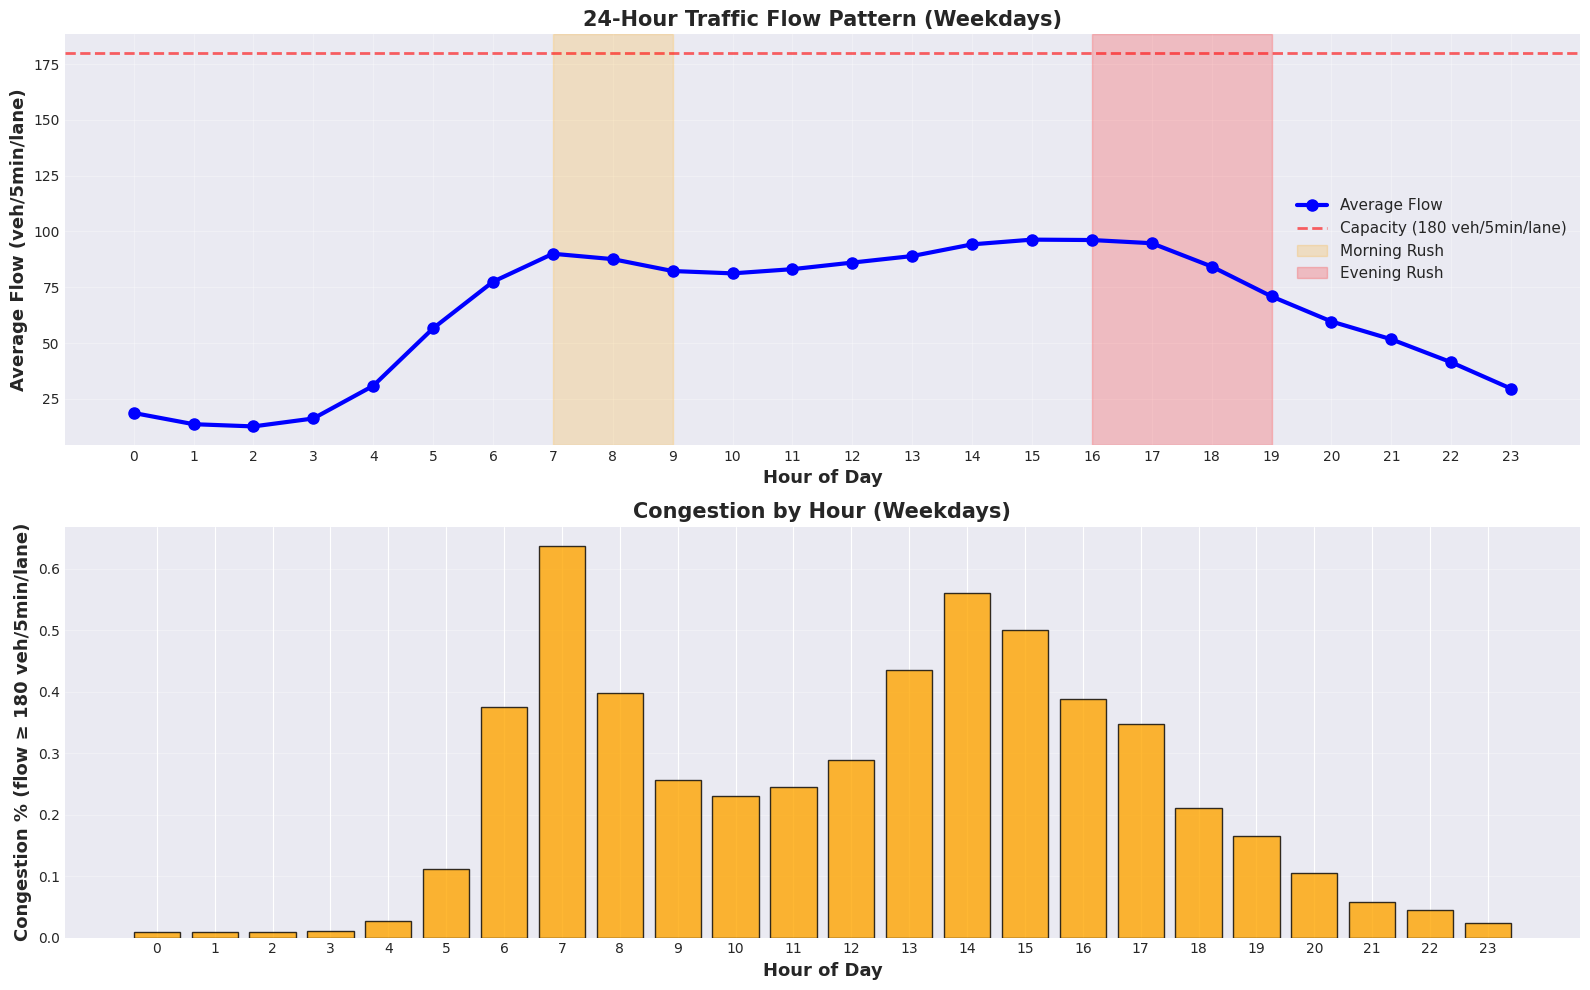

Hourly patterns plot saved


In [50]:
print("\n" + "="*100)
print("HOURLY TRAFFIC PATTERNS")
print("="*100)

# Compute average flow by hour across all sensors
hourly_patterns = (
    clean_df_with_hour
    .filter(col("day_of_week").between(2, 6))  # Weekdays only
    .groupBy("hour")
    .agg(
        avg(col("value") / col("Lanes")).alias("avg_flow_per_lane"),
        (spark_sum(when(col("value") / col("Lanes") >= 180, 1).otherwise(0)) / 
         spark_count("*") * 100).alias("congestion_pct")
    )
    .orderBy("hour")
).toPandas()

# Plot hourly patterns
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Flow by hour
ax1 = axes[0]
ax1.plot(hourly_patterns['hour'], hourly_patterns['avg_flow_per_lane'],
         marker='o', linewidth=3, markersize=8, color='blue', label='Average Flow')
ax1.axhline(y=180, color='red', linestyle='--', linewidth=2, alpha=0.6,
           label='Capacity (180 veh/5min/lane)')
ax1.axvspan(7, 9, alpha=0.2, color='orange', label='Morning Rush')
ax1.axvspan(16, 19, alpha=0.2, color='red', label='Evening Rush')
ax1.set_xlabel('Hour of Day', fontsize=13, fontweight='bold')
ax1.set_ylabel('Average Flow (veh/5min/lane)', fontsize=13, fontweight='bold')
ax1.set_title('24-Hour Traffic Flow Pattern (Weekdays)', fontsize=15, fontweight='bold')
ax1.set_xticks(range(0, 24))
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Congestion by hour
ax2 = axes[1]
ax2.bar(hourly_patterns['hour'], hourly_patterns['congestion_pct'],
        color='orange', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Hour of Day', fontsize=13, fontweight='bold')
ax2.set_ylabel('Congestion % (flow ≥ 180 veh/5min/lane)', fontsize=13, fontweight='bold')
ax2.set_title('Congestion by Hour (Weekdays)', fontsize=15, fontweight='bold')
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hourly_traffic_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hourly patterns plot saved")


In [51]:
print("\n" + "="*100)
print("KEY INSIGHTS FROM PEAK-HOUR ANALYSIS")
print("="*100)

# Calculate key metrics
weekday_peak_row = period_stats_df[period_stats_df['time_period'] == 'Weekday_Peak'].iloc[0]
weekday_offpeak_row = period_stats_df[period_stats_df['time_period'] == 'Weekday_OffPeak'].iloc[0]

peak_flow = weekday_peak_row['mean_flow_per_lane']
offpeak_flow = weekday_offpeak_row['mean_flow_per_lane']
peak_congestion = weekday_peak_row['mean_congestion']
offpeak_congestion = weekday_offpeak_row['mean_congestion']

print(f"\n1. PEAK VS OFF-PEAK FLOW:")
print(f"   Weekday Peak:     {peak_flow:6.1f} veh/5min/lane ({peak_flow/180*100:5.1f}% capacity)")
print(f"   Weekday Off-Peak: {offpeak_flow:6.1f} veh/5min/lane ({offpeak_flow/180*100:5.1f}% capacity)")
print(f"   Difference:       {peak_flow - offpeak_flow:6.1f} veh/5min/lane ({(peak_flow/offpeak_flow - 1)*100:5.1f}% increase)")

print(f"\n2. PEAK VS OFF-PEAK CONGESTION:")
print(f"   Weekday Peak:     {peak_congestion:5.1f}% of time at/over capacity")
print(f"   Weekday Off-Peak: {offpeak_congestion:5.1f}% of time at/over capacity")
if offpeak_congestion > 0:
    print(f"   Ratio:            {peak_congestion/offpeak_congestion:5.1f}× more congestion during peak")

print(f"\n3. SYSTEM UTILIZATION:")
if peak_flow >= 180:
    print(f"   CRITICAL: Peak hours operate at/over capacity!")
elif peak_flow >= 150:
    print(f"   WARNING: Peak hours near capacity (>{150/180*100:.0f}%)")
elif peak_flow >= 120:
    print(f"   CAUTION: Peak hours approaching capacity (>{120/180*100:.0f}%)")
else:
    print(f"   Peak hours below capacity (<{120/180*100:.0f}%)")

print(f"\n4. WHY 24-HOUR AVERAGES ARE MISLEADING:")
all_time_avg = sensor_stats.select(avg("avg_flow_per_lane")).collect()[0][0]
print(f"   24-hour average:  {all_time_avg:6.1f} veh/5min/lane ({all_time_avg/180*100:5.1f}% capacity)")
print(f"   Peak-hour actual: {peak_flow:6.1f} veh/5min/lane ({peak_flow/180*100:5.1f}% capacity)")
print(f"   → 24-hour average UNDERESTIMATES peak utilization by {(peak_flow - all_time_avg)/all_time_avg*100:.0f}%!")

print("\n" + "="*100)
print("PEAK-HOUR ANALYSIS COMPLETE")
print("="*100)
print("\nConclusion: Peak-hour analysis reveals the TRUE congestion patterns that are")
print("masked by 24-hour averages. During rush hours (7-9am, 4-7pm), traffic flow")
print("and congestion are SIGNIFICANTLY higher than daily averages suggest!")



KEY INSIGHTS FROM PEAK-HOUR ANALYSIS

1. PEAK VS OFF-PEAK FLOW:
   Weekday Peak:       90.4 veh/5min/lane ( 50.2% capacity)
   Weekday Off-Peak:   57.3 veh/5min/lane ( 31.8% capacity)
   Difference:         33.1 veh/5min/lane ( 57.7% increase)

2. PEAK VS OFF-PEAK CONGESTION:
   Weekday Peak:       0.4% of time at/over capacity
   Weekday Off-Peak:   0.2% of time at/over capacity
   Ratio:              2.1× more congestion during peak

3. SYSTEM UTILIZATION:
   Peak hours below capacity (<67%)

4. WHY 24-HOUR AVERAGES ARE MISLEADING:
   24-hour average:    62.2 veh/5min/lane ( 34.6% capacity)
   Peak-hour actual:   90.4 veh/5min/lane ( 50.2% capacity)
   → 24-hour average UNDERESTIMATES peak utilization by 45%!

PEAK-HOUR ANALYSIS COMPLETE

Conclusion: Peak-hour analysis reveals the TRUE congestion patterns that are
masked by 24-hour averages. During rush hours (7-9am, 4-7pm), traffic flow
and congestion are SIGNIFICANTLY higher than daily averages suggest!
